#### TOPIC: RESILIENT MACHINE LEARNING-BASED FORECASTING OF ELECTRICITY DEMAND IN THE CONTEXT OF CLIMATE CHANGE. A CASE STUDY OF THE DYNAMIC WEATHER PATTERNS OF THE NORDIC COUNTRIES.

How does the performance of machine learning models compare with traditional econometric models in electricity demand forecasting?


What strategies can enhance the ability of these models to provide accurate demand forecasts?

Which ML model is resilient?

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.sm_exceptions import ValueWarning
import statsmodels.stats.diagnostic as diagnostic
import statsmodels.tools.eval_measures as eval_measures
import statsmodels.tsa.vector_ar.var_model as var_model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import json
import warnings
from libtad import HolidaysService
from libtad.datatypes.holidays import HolidayType
from joblib import load
from joblib import dump
import os

In [2]:
df = pd.read_csv("nordext_df_climate.csv")

In [3]:
df

,Load Date,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Day of Week,Month,Year,...,Climate_Change_Nor,Climate_Change_Swe,Climate_Change_Fin,Season,Climate Change - Norway,Climate Change - Sweden,Climate Change - Finland,Climate_Change_Norway,Climate_Change_Sweden,Climate_Change_Finland
0,1/1/2010,19067,19703,11427,-11.30,-7.62,-15.11,Friday,1,2010,...,0,0,0,Winter,False,False,False,1,1,0
1,1/2/2010,19566,20316,12129,-15.99,-9.00,-19.03,Saturday,1,2010,...,0,0,0,Winter,False,False,False,0,0,0
2,1/3/2010,19531,20844,11925,-14.84,-12.53,-15.06,Sunday,1,2010,...,0,0,0,Winter,False,False,False,0,0,0
3,1/4/2010,20426,21913,12250,-12.64,-12.80,-7.33,Monday,1,2010,...,0,0,0,Winter,False,False,False,0,0,1
4,1/5/2010,21402,23337,12726,-19.60,-16.35,-13.74,Tuesday,1,2010,...,0,0,0,Winter,False,False,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5108,12/27/2023,20125,18863,10688,-8.08,-8.57,-7.20,Wednesday,12,2023,...,0,0,0,Winter,False,False,False,1,0,1
5109,12/28/2023,20151,18044,10976,-8.64,-3.80,-4.25,Thursday,12,2023,...,0,0,1,Winter,False,False,False,1,1,1
5110,12/29/2023,19551,17388,11279,-8.05,-0.20,-2.93,Friday,12,2023,...,0,1,1,Winter,False,False,False,1,1,1
5111,12/30/2023,19033,17182,11327,-7.72,-1.63,-7.31,Saturday,12,2023,...,0,1,0,Winter,False,False,False,1,1,1


In [4]:
# Specifying the path to my folder
my_plots = r'E:\ACADEMICS\THESIS\Thesis_all_plots\log_nor'

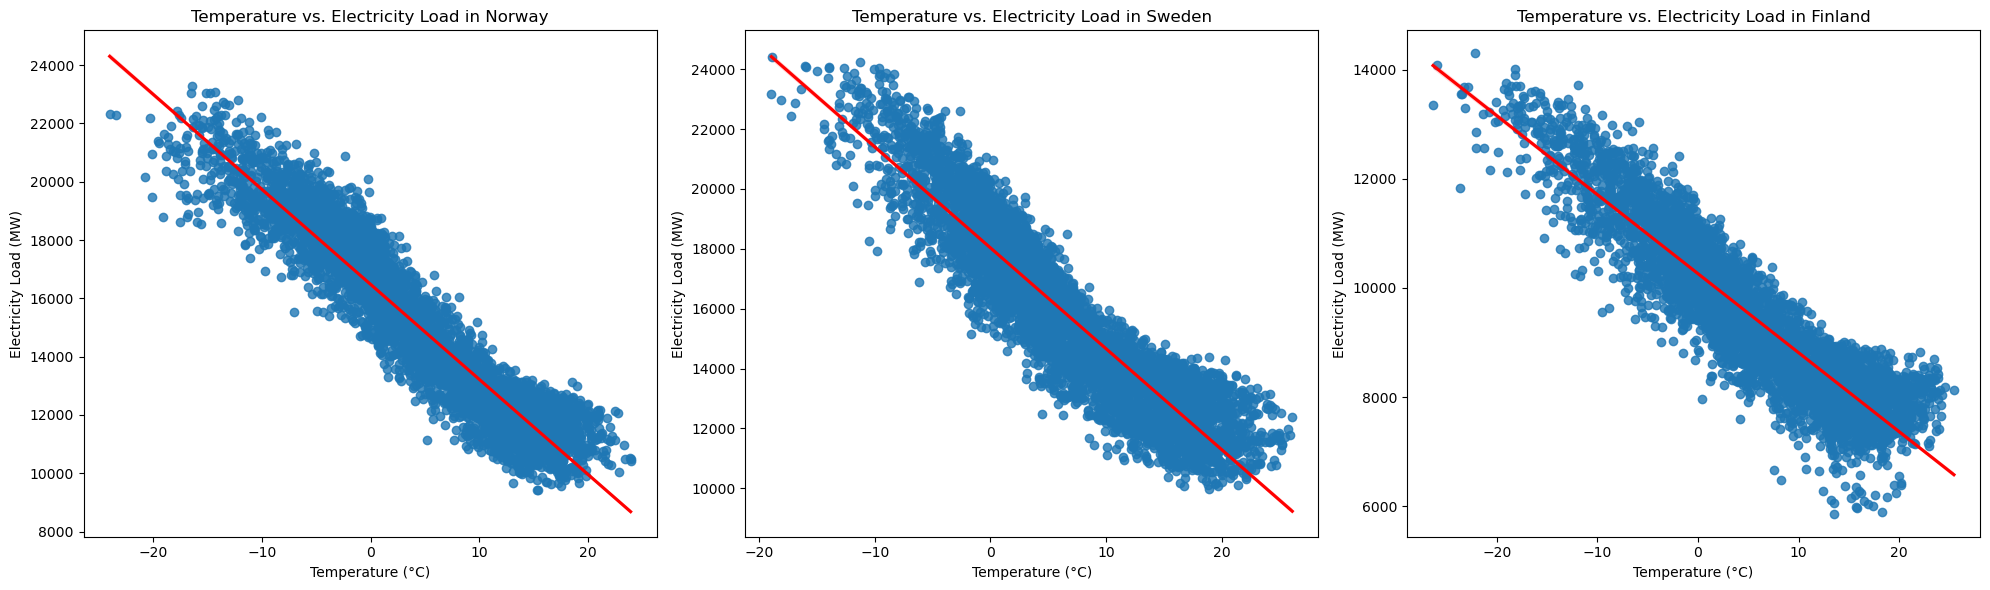

In [5]:
plt.figure(figsize=[20, 6])

# Temperature vs Electricity Load in Norway
plt.subplot(1, 3, 1)
sns.regplot(x='Temp - Norway', y='Total Load [MW] - Norway', data=df, line_kws={"color": "red"})
plt.title('Temperature vs. Electricity Load in Norway')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')

# Temperature vs Electricity Load in Sweden
plt.subplot(1, 3, 2)
sns.regplot(x='Temp - Sweden', y='Total Load [MW] - Sweden', data=df, line_kws={"color": "red"})
plt.title('Temperature vs. Electricity Load in Sweden')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')

# Temperature vs Electricity Load in Finland
plt.subplot(1, 3, 3)
sns.regplot(x='Temp - Finland', y='Total Load [MW] - Finland', data=df, line_kws={"color": "red"})
plt.title('Temperature vs. Electricity Load in Finland')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')
plt.tight_layout()

# Save the plot to the folder
plt.savefig(os.path.join(my_plots, 'plot1.png'), dpi = 600)  # Save as PNG format

plt.show()

In [6]:
# List of countries
countries = ['Norway', 'Sweden', 'Finland']

# Apply logarithmic transformation to the load and temperature for each country
for country in countries:
    # Add a constant to ensure all temperatures are positive before taking log
    df[f'Log Total Load - {country}'] = np.log(df[f'Total Load [MW] - {country}'])
    df[f'Log Temp - {country}'] = np.log(df[f'Temp - {country}'] + 30)  # Adding 30 to ensure all temperatures are positive

# Display the first few rows to verify the new columns
for country in countries:
    print(df[[f'Log Total Load - {country}', f'Log Temp - {country}']].head())

   Log Total Load - Norway  Log Temp - Norway
0                 9.855714           2.928524
1                 9.881549           2.639771
2                 9.879758           2.718660
3                 9.924564           2.854169
4                 9.971240           2.341806
   Log Total Load - Sweden  Log Temp - Sweden
0                 9.888526           3.108168
1                 9.919164           3.044522
2                 9.944821           2.860485
3                 9.994835           2.844909
4                10.057795           2.613740
   Log Total Load - Finland  Log Temp - Finland
0                  9.343734            2.700690
1                  9.403355            2.395164
2                  9.386392            2.704042
3                  9.413281            3.121042
4                  9.451402            2.788708


In [7]:
# Converting 'Load Date' into datetime format and setting it as the index
df['Load Date'] = pd.to_datetime(df['Load Date'])
df.set_index('Load Date', inplace=True)

# Splitting the data into training and testing sets
training_data = df.loc['2010-01-01':'2020-12-31'] #first eleven years
testing_data = df.loc['2021-01-01':'2023-12-31']  #Last three years

# Displaying the shapes of the training and testing sets as a quick verification
training_data.shape, testing_data.shape

((4018, 37), (1095, 37))

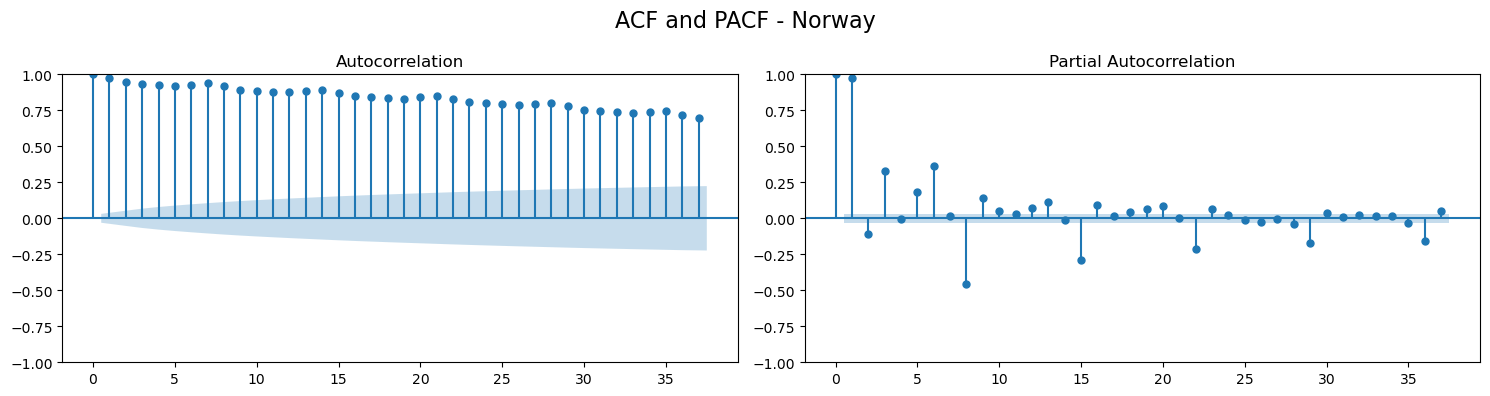

In [8]:
# Selecting Norway's Total Load for demonstration
ts_norway_load = training_data['Total Load [MW] - Norway']

# Performing a stationarity test
adf_test_result = adfuller(ts_norway_load)

# Preparing to plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle('ACF and PACF - Norway', fontsize=16)  # Add heading
# Plotting Autocorrelation Function (ACF)
plot_acf(ts_norway_load, ax=axes[0])

# Plotting Partial Autocorrelation Function (PACF)
plot_pacf(ts_norway_load, ax=axes[1], method='ywm')

plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'plot2.png'), dpi = 600)  # Save as PNG format

plt.show()

# adf_test_result

In [9]:
# Function to perform the Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # Drop na to make sure the test works on non-NaN values
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        out[f'critical value ({key})'] = value
    print(out.to_string())  # .to_string() to print all lines

# Testing for stationarity on the 'Total Load [MW] - Norway' column
print("Total Load [MW] - Norway:")
adf_test(df['Total Load [MW] - Norway'], 'Total Load [MW] - Norway')

# Testing for stationarity on the 'Temp - Norway' column
print("\nTemp - Norway:")
adf_test(df['Temp - Norway'], 'Temp - Norway')


Total Load [MW] - Norway:
Augmented Dickey-Fuller Test: Total Load [MW] - Norway
ADF test statistic        -4.928490
p-value                    0.000031
# lags used               29.000000
# observations          5083.000000
critical value (1%)       -3.431637
critical value (5%)       -2.862109
critical value (10%)      -2.567073

Temp - Norway:
Augmented Dickey-Fuller Test: Temp - Norway
ADF test statistic        -4.799218
p-value                    0.000055
# lags used               30.000000
# observations          5082.000000
critical value (1%)       -3.431637
critical value (5%)       -2.862109
critical value (10%)      -2.567073


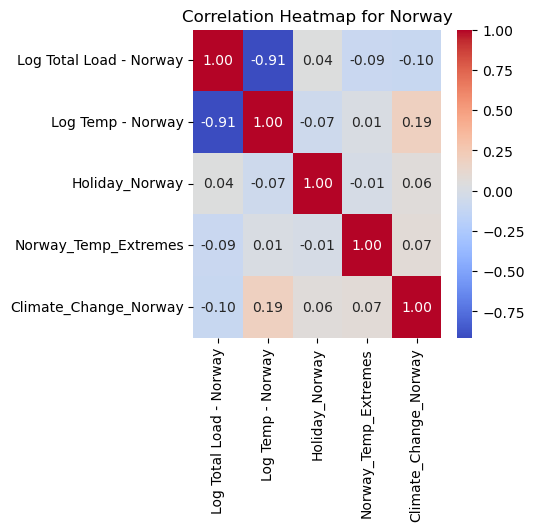

In [10]:
# Selecting columns relevant to Norway for correlation analysis
norway_columns = ['Log Total Load - Norway', 'Log Temp - Norway', 'Holiday_Norway','Norway_Temp_Extremes', 'Climate_Change_Norway']
norway_df = df[norway_columns]

# Calculating correlation matrix
correlation_matrix_norway = norway_df.corr()

# Plotting the heatmap for Norway
plt.figure(figsize=(4, 4))
sns.heatmap(correlation_matrix_norway, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Norway')
plt.savefig(os.path.join(my_plots, 'corrr.png'), dpi=600)  # Saving as PNG format at high resolution

plt.show()

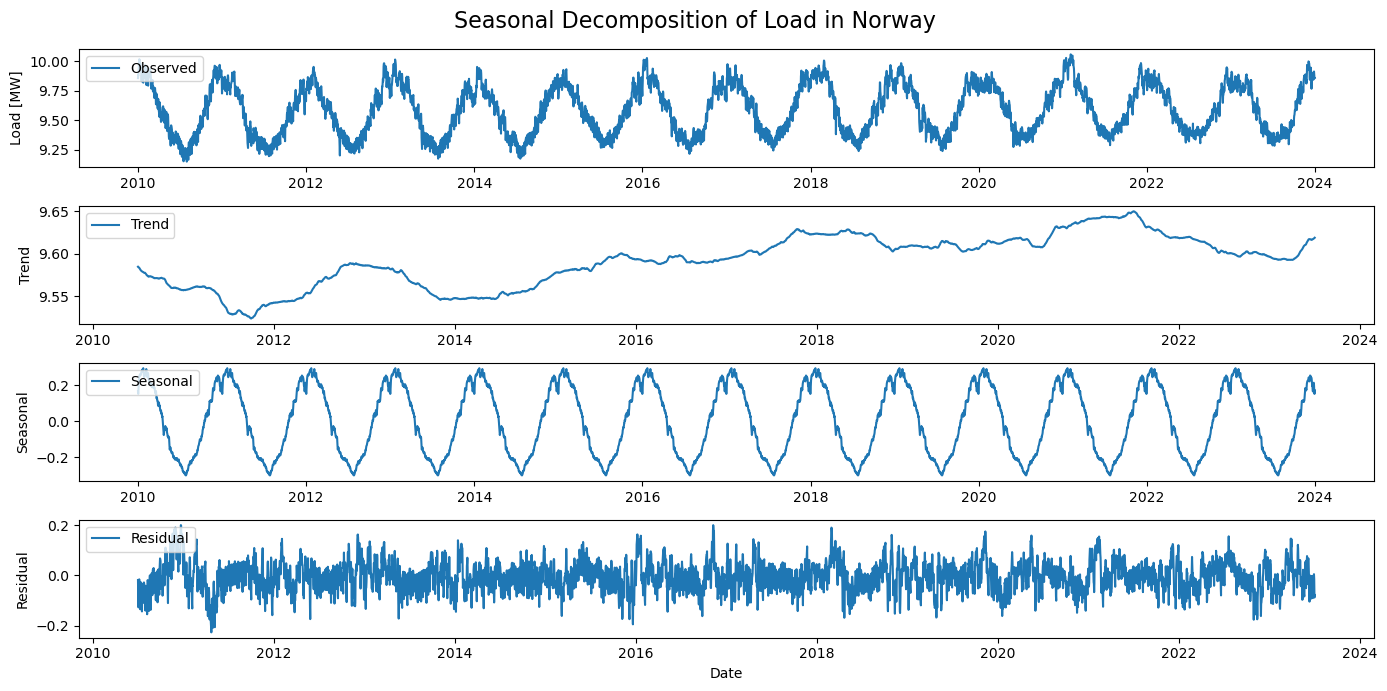

In [11]:
# Seasonal decomposition for Sweden load data
decomposed_norway = seasonal_decompose(df['Log Total Load - Norway'], model='additive', period=365)

# Plotting the decomposed components for Sweden load data
plt.figure(figsize=(14, 7))
plt.suptitle('Seasonal Decomposition of Load in Norway', fontsize=16)  # Add heading
plt.subplot(411)
plt.plot(decomposed_norway.observed, label='Observed')
plt.legend(loc='upper left')
plt.ylabel('Load [MW]')  # Add y-axis label
plt.subplot(412)
plt.plot(decomposed_norway.trend, label='Trend')
plt.legend(loc='upper left')
plt.ylabel('Trend')  # Add y-axis label
plt.subplot(413)
plt.plot(decomposed_norway.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.ylabel('Seasonal')  # Add y-axis label
plt.subplot(414)
plt.plot(decomposed_norway.resid, label='Residual')
plt.legend(loc='upper left')
plt.ylabel('Residual')  # Add y-axis label
plt.xlabel('Date')  # Add x-axis label
plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'decompose.png'), dpi=600)  # Save as PNG format
plt.show()

In [12]:
warnings.simplefilter('ignore', ValueWarning)

In [13]:
# Resample to monthly data and aggregate appropriately
monthly_data = df.resample('ME').agg({
    'Log Total Load - Norway': 'sum',  # Sum of load for the month
    'Temp - Norway': 'mean',            # Average temperature for the month
    'Holiday_Norway': 'sum',            # Total count of holiday days in the month
    'Norway_Temp_Extremes': 'sum',      # Total count of days with climate variability
    'Climate_Change_Norway': 'sum'      # Total count of days with temperatures above the mean 
})

# Split into training and testing sets
y_train = monthly_data.loc['2010-01-01':'2019-12-31', 'Log Total Load - Norway']
X_train = monthly_data.loc['2010-01-01':'2019-12-31', ['Temp - Norway','Holiday_Norway']]
y_test = monthly_data.loc['2020-01-01':'2023-12-31', 'Log Total Load - Norway']
X_test = monthly_data.loc['2020-01-01':'2023-12-31', ['Temp - Norway','Holiday_Norway']]

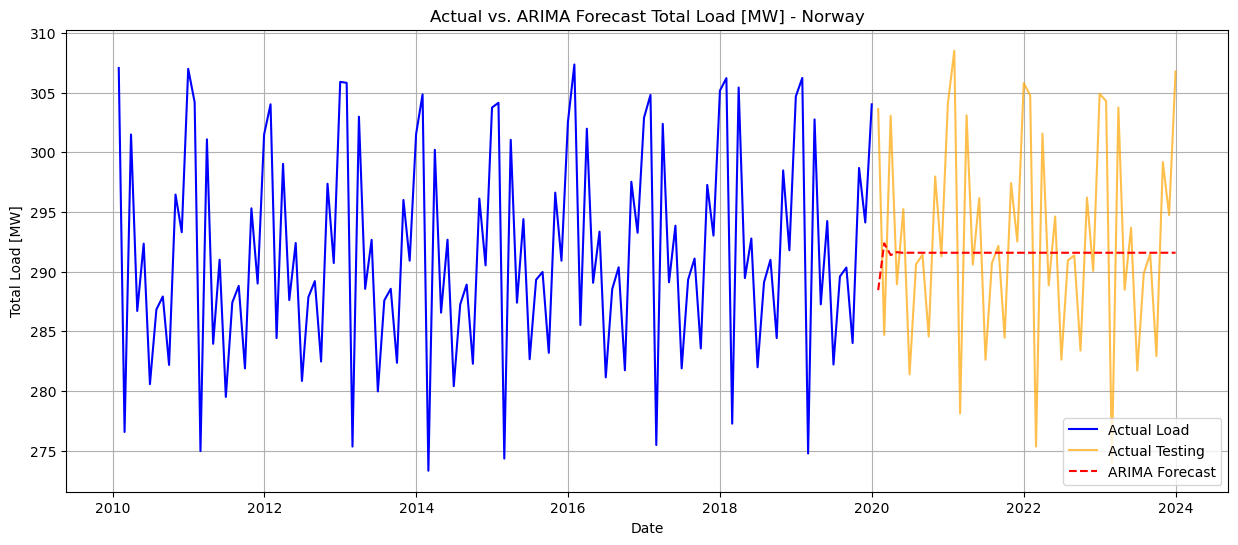

(9.59190133072322, 29.429575439781136)

In [14]:
# Fitting an ARIMA(1,1,1) model to Norway's total load data, without using exogenous variables in this part
model_arima_norway = SARIMAX(y_train, order=(1,1,1), seasonal_order=(0,0,0,0))
model_arima_fit_norway = model_arima_norway.fit()

# Making predictions on the training data for comparison
train_pred_norway = model_arima_fit_norway.predict(start=y_train.index[0], end=y_train.index[-1])

# Making forecasts on the test data
test_forecast_norway = model_arima_fit_norway.predict(start=y_test.index[0], end=y_test.index[-1])

# Plotting without training predictions for a clearer view of actual vs. forecasted in the test period
plt.figure(figsize=(15, 6))

# Plotting training data (actual)
plt.plot(y_train.index, y_train, label='Actual Load', color='blue')

# Plotting testing data (actual)
plt.plot(y_test.index, y_test, label='Actual Testing', color='orange', alpha=0.7)

# Plotting testing forecasts
plt.plot(test_forecast_norway.index, test_forecast_norway, label='ARIMA Forecast', color='red', linestyle='--')

plt.title('Actual vs. ARIMA Forecast Total Load [MW] - Norway')
plt.xlabel('Date')
plt.ylabel('Total Load [MW]')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(my_plots, 'plot4.png'), dpi = 600)  # Save as PNG format
plt.show()

# Evaluating model performance on the training set
mae_norway = mean_absolute_error(y_train, train_pred_norway)
rmse_norway = np.sqrt(mean_squared_error(y_train, train_pred_norway))

mae_norway, rmse_norway

The ADF (Augmented Dickey-Fuller) test results for Norway's total electricity load time series indicate that the series is stationary, given that the p-value (0.00011) is less than the common significance level of 0.05. This suggests that we do not need to difference the data to achieve stationarity.

The ACF plot shows a gradual decline, which suggests a moving average component might be present.
The PACF plot has a significant drop after the first lag, indicating an autoregressive component of order 1 could be a good starting point. Based on these observations, a simple ARIMA model with parameters (1,0,1) could be a reasonable starting model. This means we would be looking at an ARIMA model with 1 autoregressive term, no differencing (since the series is already stationary), and 1 moving average term.

Adding temperature to the ARIMA model means moving towards a more complex model that can incorporate external variables, transforming it into a SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) model. ARIMA models are univariate, meaning they forecast based on past values of the series itself. SARIMAX, on the other hand, allows for the inclusion of other influencing factors (in this case, temperature), which can significantly improve forecasting accuracy, especially in my context where temperature is a key factor in electricity demand.
I proceed by fitting a SARIMAX model with the temperature as an exogenous variable using the same (1,1,1) configuration for the ARIMA component and adding the average temperature for Norway as the exogenous variable. We fit this model to the training data and then make forecasts for the test period.

## BUILDING SARIMAX

In [15]:
# Defining the target and exogenous variables for the SARIMAX model
# Building and fitting the SARIMAX model
sarimax_model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_result = sarimax_model.fit()

# Making predictions on the test set
predictions = sarimax_result.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

# Calculating RMSE for the model's predictions
rmse = np.sqrt(mean_squared_error(y_test, predictions))
sarimax_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Log Total Load - Norway   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -197.137
Date:                            Mon, 17 Jun 2024   AIC                            408.274
Time:                                    10:27:51   BIC                            426.984
Sample:                                01-31-2010   HQIC                           415.859
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Temp - Norway     -0.4626      0.091     -5.074      0.000      -0.641      -0.284
Holiday_Norway    -0.0001   2.22e+05  -5.46e-10      1.000   -4.36e+05    4.36e+05
ar.L1              0.0752      0.161      0.468      0.640      -0.240       0.391
ma.L1             -0.9992      6.557     -0.152      0.879     -13.850      11.851
ar.S.L12          -0.1615      0.075     -2.163      0.031      -0.308      -0.015
ma.S.L12          -0.9994     56.181     -0.018      0.986    -111.113     109.114
sigma2             1.6350     90.160      0.018      0.986    -175.074     178.344
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2398.21
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             3.58
Prob(H) (two-sided):                  0.02   Kurtosis:                        25.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

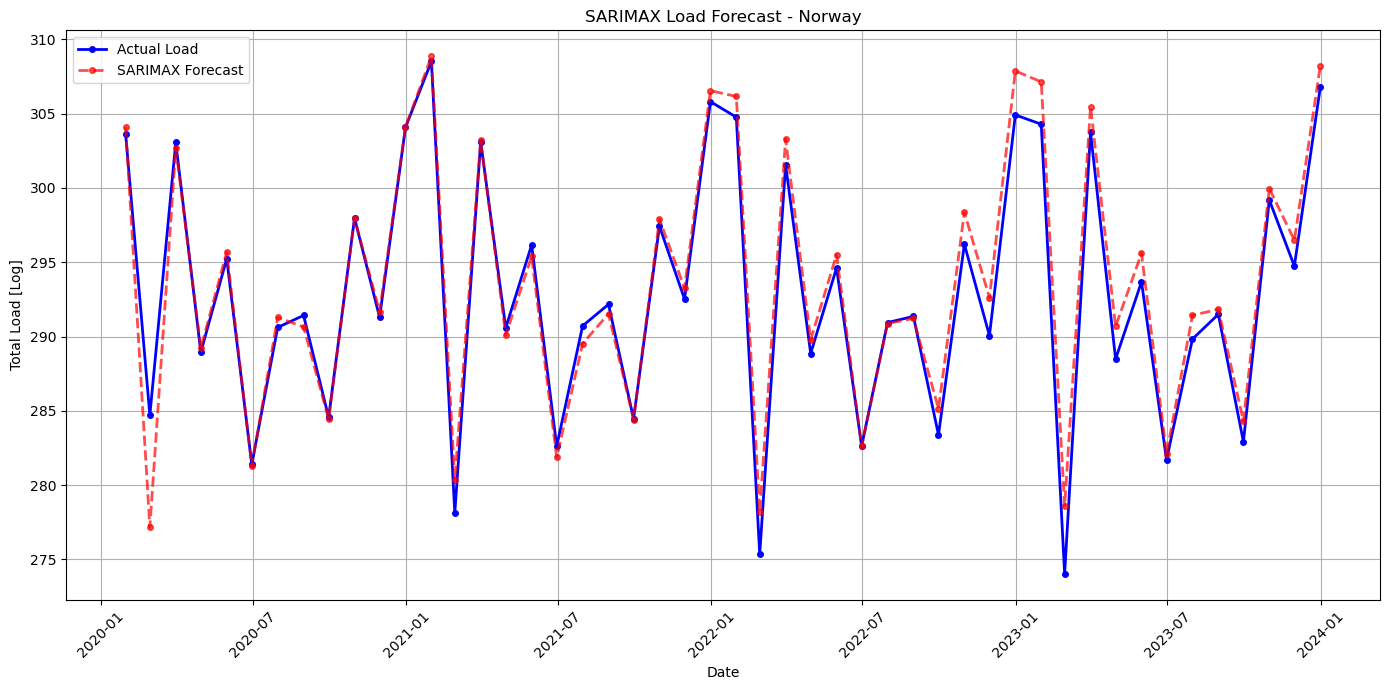

In [16]:
# Plotting the actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=2, markersize=8)
plt.plot(predictions.index, predictions, label='SARIMAX Forecast', color='red', alpha=0.7, marker='.', linestyle='--', linewidth=2, markersize=8)

plt.title('SARIMAX Load Forecast - Norway')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Adding grid to the winter predictions plot
plt.tight_layout()
# Save the plot to the folder
plt.savefig(os.path.join(my_plots, 'plot5.png'), dpi = 600)  # Save as PNG format

plt.show()

In [17]:
#mae, mape, mse
# Calculating MSE
mse_sarimax = mean_squared_error(y_test, predictions)

# Calculating MAE
mae_sarimax = mean_absolute_error(y_test, predictions)

# Calculating RMSE
rmse_sarimax = np.sqrt(mse_sarimax)

# Calculating MAPE
mape_sarimax = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print(f"MSE (SARIMAX): {mse_sarimax}")
print(f"MAE (SARIMAX): {mae_sarimax}")
print(f"RMSE (SARIMAX): {rmse_sarimax}")
print(f"MAPE (SARIMAX): {mape_sarimax}%")

MSE (SARIMAX): 3.2686561670371828
MAE (SARIMAX): 1.2089333949990113
RMSE (SARIMAX): 1.8079425231564146
MAPE (SARIMAX): 0.41629537451275495%


#### EXPANDING THE EXOGENOUS VARIABLES TO EXTREME WEATHER CONDITIONS

In [18]:
#Lets create an interaction term
# Create the interaction term
monthly_data['Clim_ext'] = monthly_data['Norway_Temp_Extremes'] * monthly_data['Climate_Change_Norway']

In [19]:
# Adjusting the selection of exogenous variables for Norway
X_train_exog = monthly_data.loc['2010-01-01':'2019-12-31',['Temp - Norway', 'Holiday_Norway', 'Norway_Temp_Extremes','Climate_Change_Norway','Clim_ext' ]]
X_test_exog = monthly_data.loc['2020-01-01':'2023-12-31', ['Temp - Norway', 'Holiday_Norway', 'Norway_Temp_Extremes', 'Climate_Change_Norway','Clim_ext']]

In [20]:
# Defining the target and exogenous variables for the SARIMAX model
# Building and fitting the SARIMAX model
sarimax_model2 = SARIMAX(y_train, exog=X_train_exog, order=(1, 1, 0), seasonal_order=(1, 1, 0, 12))
sarimax_result2 = sarimax_model2.fit()

# Making predictions on the test set
predictions2 = sarimax_result2.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test_exog)

# Calculating RMSE for the model's predictions
#rmse = np.sqrt(mean_squared_error(y_test, predictions2))

sarimax_result2.summary()

C:\Users\sammy\anaconda3\envs\thesis\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Log Total Load - Norway   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -231.621
Date:                            Mon, 17 Jun 2024   AIC                            479.242
Time:                                    10:27:54   BIC                            500.625
Sample:                                01-31-2010   HQIC                           487.910
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Temp - Norway            -0.5550      0.185     -3.006      0.003      -0.917      -0.193
Holiday_Norway        -4.499e-07   6.03e-07     -0.746      0.456   -1.63e-06    7.33e-07
Norway_Temp_Extremes     -0.0071      0.115     -0.061      0.951      -0.233       0.219
Climate_Change_Norway     0.0072      0.075      0.095      0.924      -0.140       0.154
Clim_ext                  0.0012      0.006      0.204      0.838      -0.010       0.013
ar.L1                    -0.5229      0.062     -8.392      0.000      -0.645      -0.401
ar.S.L12                 -0.4710      0.050     -9.410      0.000      -0.569      -0.373
sigma2                    4.3016      0.413     10.415      0.000       3.492       5.111
===================================================================================
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):               403.14
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             1.26
Prob(H) (two-sided):                  0.05   Kurtosis:                        12.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.49e+18. Standard errors may be unstable.
"""

In [21]:
# Calculating MSE
mse_sarimax2 = mean_squared_error(y_test, predictions2)

# Calculating MAE
mae_sarimax2 = mean_absolute_error(y_test, predictions2)

# Calculating RMSE
rmse_sarimax2 = np.sqrt(mse_sarimax2)

# Calculating MAPE
mape_sarimax2 = np.mean(np.abs((y_test - predictions2) / y_test)) * 100

print(f"MSE (SARIMAX2): {mse_sarimax2}")
print(f"MAE (SARIMAX2): {mae_sarimax2}")
print(f"RMSE (SARIMAX2): {rmse_sarimax2}")
print(f"MAPE (SARIMAX2): {mape_sarimax2}%")

MSE (SARIMAX2): 3.388402674449543
MAE (SARIMAX2): 0.9388280066072051
RMSE (SARIMAX2): 1.8407614387664533
MAPE (SARIMAX2): 0.3222238596127361%


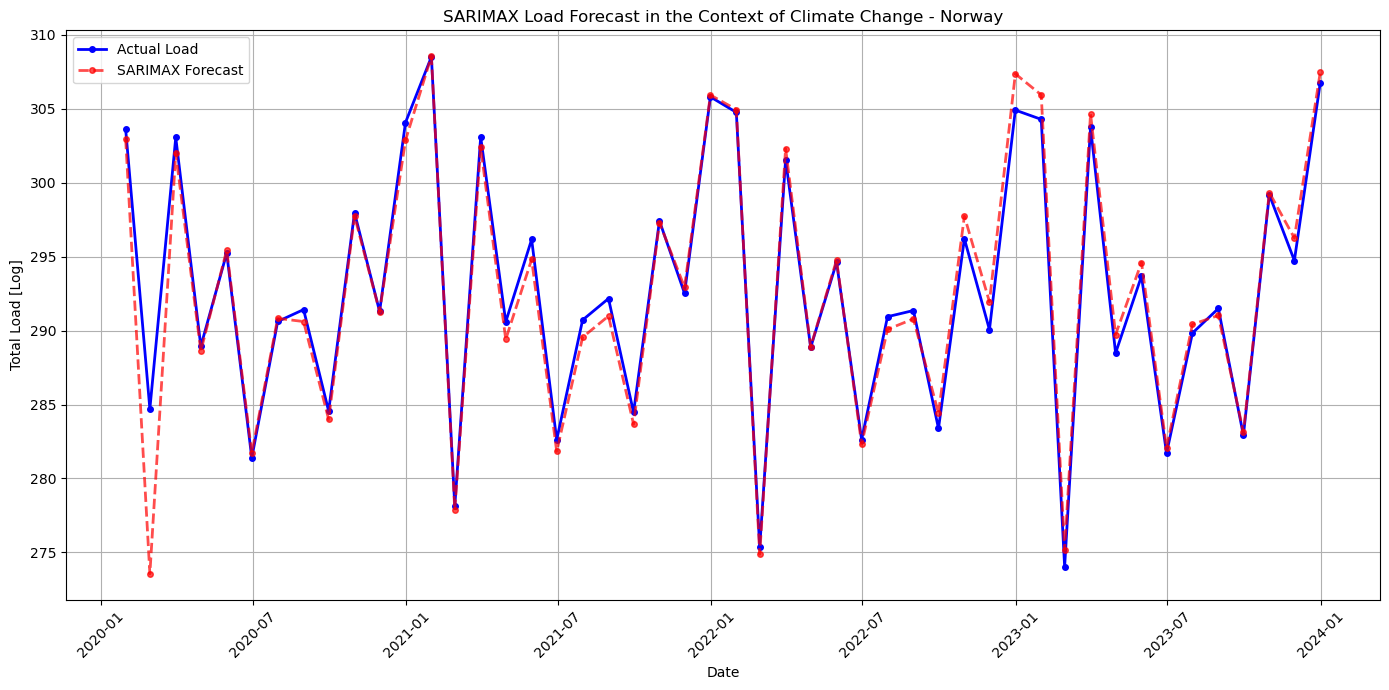

In [22]:
# Plotting the actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=2, markersize=8)
plt.plot(predictions2.index, predictions2, label='SARIMAX Forecast', color='red', alpha=0.7, marker='.', linestyle='--', linewidth=2, markersize=8)

plt.title('SARIMAX Load Forecast in the Context of Climate Change - Norway')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Adding grid to the winter predictions plot
plt.tight_layout()
# Save the plot to the folder
plt.savefig(os.path.join(my_plots, 'plot5_sarimax2.png'), dpi = 600)  # Save as PNG format

plt.show()

# NOW LET US DEPLOY OUR MACHINE LEARNING MODELS

In [23]:
# Feature Engineering: Creating time-based features from the index
monthly_data['Month'] = monthly_data.index.month
monthly_data['Year'] = monthly_data.index.year

# Selecting the features and target variable
features = ['Temp - Norway', 'Month', 'Year']
target = 'Log Total Load - Norway'

# Splitting the dataset into features (X) and target (y) for the machine learning model
X = monthly_data[features]
y = monthly_data[target]

# Splitting the data into training and testing sets for the machine learning model (using the same date range as before)
X_train_ml, X_test_ml = X.loc['2010-01-01':'2019-12-31'], X.loc['2020-01-01':'2023-12-31']
y_train_ml, y_test_ml = y.loc['2010-01-01':'2019-12-31'], y.loc['2020-01-01':'2023-12-31']

# Data Preprocessing: Standardizing the features
scaler = StandardScaler()
X_train_ml_scaled = scaler.fit_transform(X_train_ml)
X_test_ml_scaled = scaler.transform(X_test_ml)

# Model Selection: Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
rf_regressor.fit(X_train_ml_scaled, y_train_ml)

# Making predictions
predictions_ml = rf_regressor.predict(X_test_ml_scaled)

# Evaluating the model
mse_ml = mean_squared_error(y_test_ml, predictions_ml)
rmse_ml = np.sqrt(mse_ml)
mae_ml = mean_absolute_error(y_test_ml, predictions_ml)
mape_ml = np.mean(np.abs((y_test_ml - predictions_ml) / y_test_ml)) * 100

mse_ml, rmse_ml, mae_ml, mape_ml


(4.223455037078118, 2.0551046292289152, 1.4337636772445397, 0.4893066829091599)

In [24]:
# Making predictions on the training set
train_predictions_ml = rf_regressor.predict(X_train_ml_scaled)

# Evaluating the model on the training set
mse_in_sample_ml = mean_squared_error(y_train_ml, train_predictions_ml)
rmse_in_sample_ml = np.sqrt(mse_in_sample_ml)
mae_in_sample_ml = mean_absolute_error(y_train_ml, train_predictions_ml)
mape_in_sample_ml = np.mean(np.abs((y_train_ml - train_predictions_ml) / y_train_ml)) * 100

# Printing the in-sample evaluation metrics
print("In-sample Evaluation Metrics for Random Forest Regressor:")
print(f"MSE (In-sample): {mse_in_sample_ml}")
print(f"RMSE (In-sample): {rmse_in_sample_ml}")
print(f"MAE (In-sample): {mae_in_sample_ml}")
print(f"MAPE (In-sample): {mape_in_sample_ml}%")

In-sample Evaluation Metrics for Random Forest Regressor:
MSE (In-sample): 0.6623515901562896
RMSE (In-sample): 0.8138498572564166
MAE (In-sample): 0.5195455472807969
MAPE (In-sample): 0.17996826824090512%


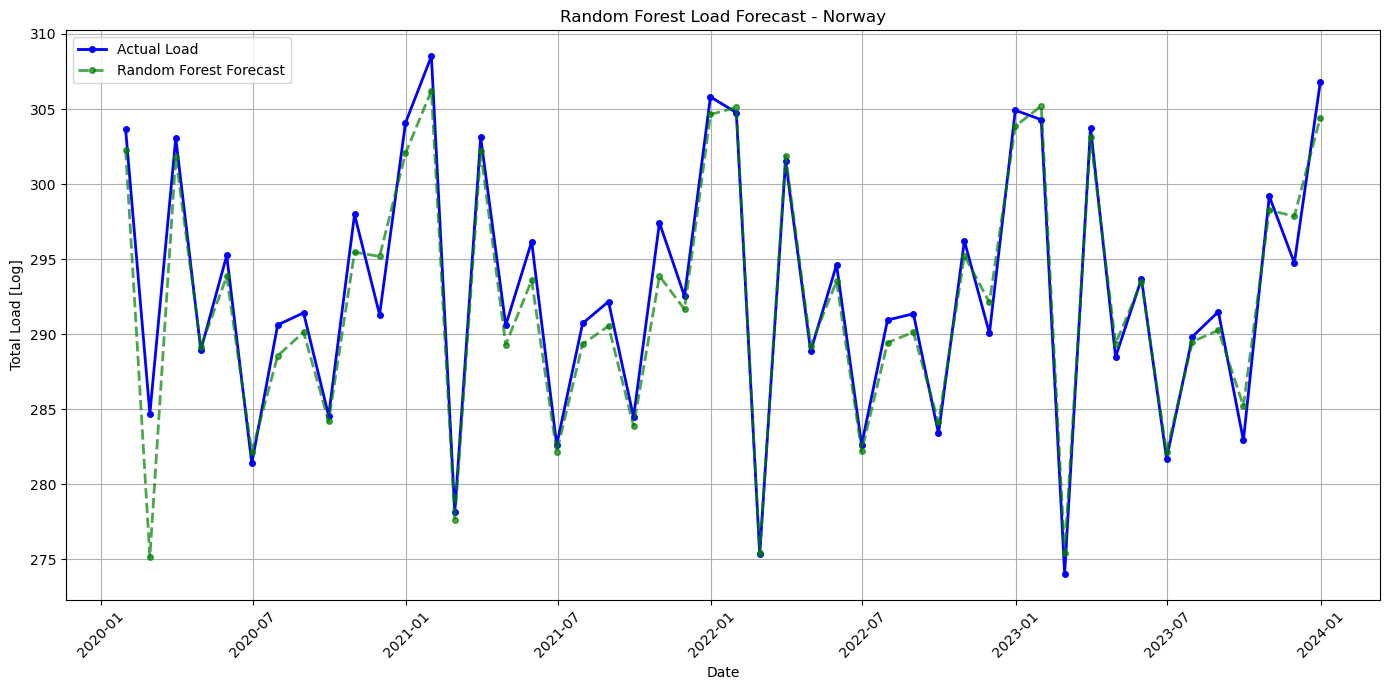

In [25]:
# Plotting the actual vs. predicted values from the Random Forest model
plt.figure(figsize=(14, 7))
plt.plot(y_test_ml.index, y_test_ml, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=2, markersize=8)
plt.plot(y_test_ml.index, predictions_ml, label='Random Forest Forecast', color='green', alpha=0.7, marker='.', linestyle='--', linewidth=2, markersize=8)

plt.title('Random Forest Load Forecast - Norway')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Adding grid to the winter predictions plot
plt.tight_layout()
# Save the plot to the folder
plt.savefig(os.path.join(my_plots, 'plot6.png'), dpi = 600)  # Save as PNG format

plt.show()

In [26]:
# Model Selection: Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Training the model
gb_regressor.fit(X_train_ml_scaled, y_train_ml)

# Making predictions
predictions_gb = gb_regressor.predict(X_test_ml_scaled)

# Evaluating the model
mse_gb = mean_squared_error(y_test_ml, predictions_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test_ml, predictions_gb)
mape_gb = np.mean(np.abs((y_test_ml - predictions_gb) / y_test_ml)) * 100

mse_gb, rmse_gb, mae_gb, mape_gb


(3.900936432542187, 1.9750788421078758, 1.3367175241802538, 0.4559323959342654)

In [27]:
# Making predictions on the training set for the Gradient Boosting model
train_predictions_gb = gb_regressor.predict(X_train_ml_scaled)

# Evaluating the model on the training set
mse_in_sample_gb = mean_squared_error(y_train_ml, train_predictions_gb)
rmse_in_sample_gb = np.sqrt(mse_in_sample_gb)
mae_in_sample_gb = mean_absolute_error(y_train_ml, train_predictions_gb)
mape_in_sample_gb = np.mean(np.abs((y_train_ml - train_predictions_gb) / y_train_ml)) * 100

# Printing the in-sample evaluation metrics for the Gradient Boosting Regressor
print("In-sample Evaluation Metrics for Gradient Boosting Regressor:")
print(f"MSE (In-sample): {mse_in_sample_gb}")
print(f"RMSE (In-sample): {rmse_in_sample_gb}")
print(f"MAE (In-sample): {mae_in_sample_gb}")
print(f"MAPE (In-sample): {mape_in_sample_gb}%")

In-sample Evaluation Metrics for Gradient Boosting Regressor:
MSE (In-sample): 0.4127209869805012
RMSE (In-sample): 0.6424336440290944
MAE (In-sample): 0.4857187203624084
MAPE (In-sample): 0.16795387914285304%


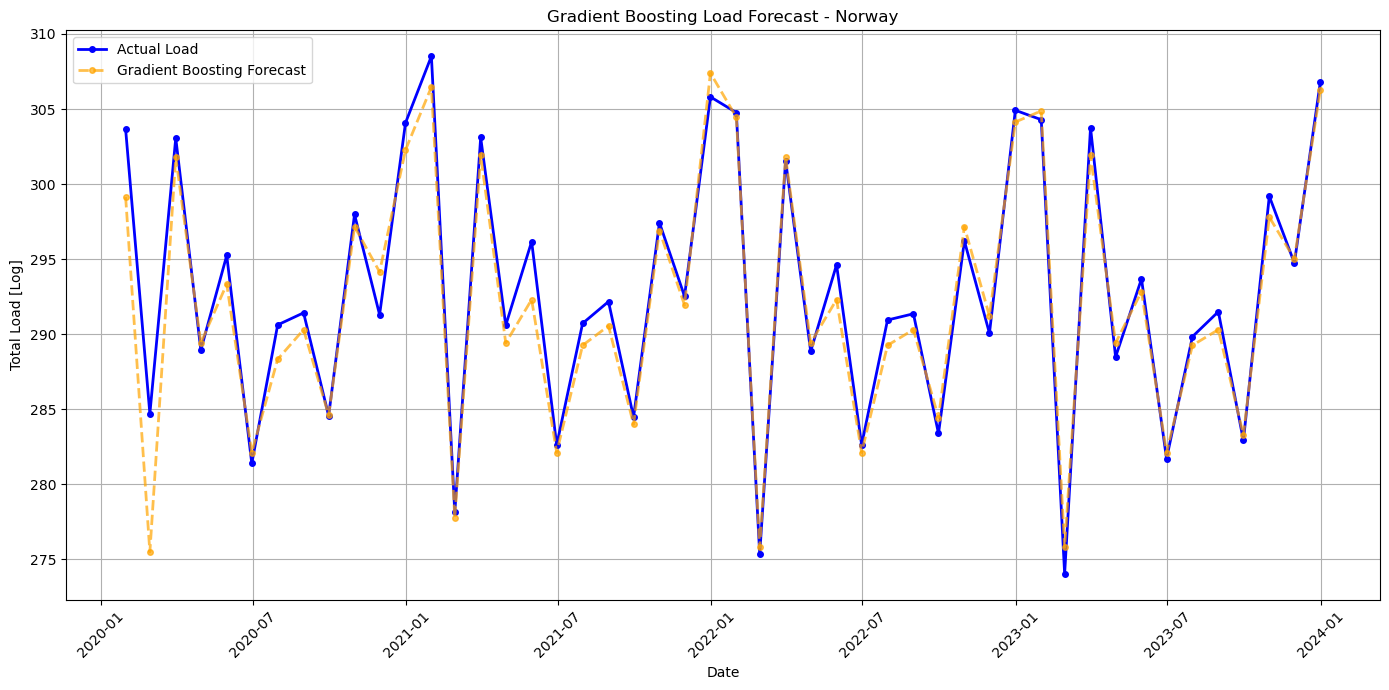

In [28]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_ml.index, y_test_ml, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=2, markersize=8)
plt.plot(y_test_ml.index, predictions_gb, label='Gradient Boosting Forecast', color='orange', alpha=0.7, marker='.', linestyle='--', linewidth=2, markersize=8)

plt.title('Gradient Boosting Load Forecast - Norway')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  
plt.tight_layout()
# Save the plot to the folder
plt.savefig(os.path.join(my_plots, 'plot7.png'), dpi = 600)  # Save as PNG format

plt.show()

# ADDING HOLIDAY AND EXTREME WEATHER CONDITIONS

In [29]:
# Feature Engineering: Creating time-based features from the index
monthly_data['Month'] = monthly_data.index.month
monthly_data['Year'] = monthly_data.index.year

# Selecting the features and target variable, now including 'Holiday_Sweden' and 'climate change'
features_ext = ['Temp - Norway', 'Month', 'Year', 'Holiday_Norway', 'Norway_Temp_Extremes', 'Climate_Change_Norway','Clim_ext']  # Added Holiday and extreme temp
target_ext = 'Log Total Load - Norway'

# Splitting the dataset into features (X) and target (y) for the machine learning model
X = monthly_data[features_ext]
y = monthly_data[target_ext]

# Splitting the data into training and testing sets for machine learning model (using the same date range as before)
X_train_ml_2, X_test_ml_2 = X.loc['2010-01-01':'2019-12-31'], X.loc['2020-01-01':'2023-12-31']
y_train_ml_2, y_test_ml_2 = y.loc['2010-01-01':'2019-12-31'], y.loc['2020-01-01':'2023-12-31']

# Data Preprocessing: Standardizing the continuous features
scaler_2 = StandardScaler()
# Selecting only continuous features for scaling
continuous_features = ['Temp - Norway', 'Month', 'Year']
X_train_ml_scaled_2 = X_train_ml_2.copy()
X_test_ml_scaled_2 = X_test_ml_2.copy()

# Applying standardization to continuous features
X_train_ml_scaled_2[continuous_features] = scaler_2.fit_transform(X_train_ml_2[continuous_features])
X_test_ml_scaled_2[continuous_features] = scaler_2.transform(X_test_ml_2[continuous_features])

# Model Selection: Creating a new instance of Random Forest Regressor
rf_regressor_2 = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the new model
rf_regressor_2.fit(X_train_ml_scaled_2, y_train_ml_2)

# Making predictions (out-of-sample)
predictions_ml_2 = rf_regressor_2.predict(X_test_ml_scaled_2)

In [30]:
# Evaluating the expanded fr model
mse_ml_2 = mean_squared_error(y_test_ml_2, predictions_ml_2)
rmse_ml_2 = np.sqrt(mse_ml_2)
mae_ml_2 = mean_absolute_error(y_test_ml_2, predictions_ml_2)
mape_ml_2 = np.mean(np.abs((y_test_ml_2 - predictions_ml_2) / y_test_ml_2)) * 100

print("MSE for RF 2:", mse_ml_2)
print("RMSE for RF 2:", rmse_ml_2)
print("MAE for RF 2:", mae_ml_2)
print("MAPE for RF 2:", mape_ml_2)

MSE for RF 2: 3.2778259036077944
RMSE for RF 2: 1.8104767061765237
MAE for RF 2: 1.374412214701599
MAPE for RF 2: 0.46874820682702667


In [31]:
# Making predictions on the training set for the expanded model
train_predictions_ml_2 = rf_regressor_2.predict(X_train_ml_scaled_2)

# Evaluating the model on the training set
mse_in_sample_ml_2 = mean_squared_error(y_train_ml_2, train_predictions_ml_2)
rmse_in_sample_ml_2 = np.sqrt(mse_in_sample_ml_2)
mae_in_sample_ml_2 = mean_absolute_error(y_train_ml_2, train_predictions_ml_2)
mape_in_sample_ml_2 = np.mean(np.abs((y_train_ml_2 - train_predictions_ml_2) / y_train_ml_2)) * 100

# Printing the in-sample evaluation metrics for the second model
print("In-sample Evaluation Metrics for Random Forest Regressor 2:")
print(f"MSE (In-sample): {mse_in_sample_ml_2}")
print(f"RMSE (In-sample): {rmse_in_sample_ml_2}")
print(f"MAE (In-sample): {mae_in_sample_ml_2}")
print(f"MAPE (In-sample): {mape_in_sample_ml_2}%")

In-sample Evaluation Metrics for Random Forest Regressor 2:
MSE (In-sample): 0.6847563073393168
RMSE (In-sample): 0.8275000346461121
MAE (In-sample): 0.5069917379315314
MAPE (In-sample): 0.1754731236202329%


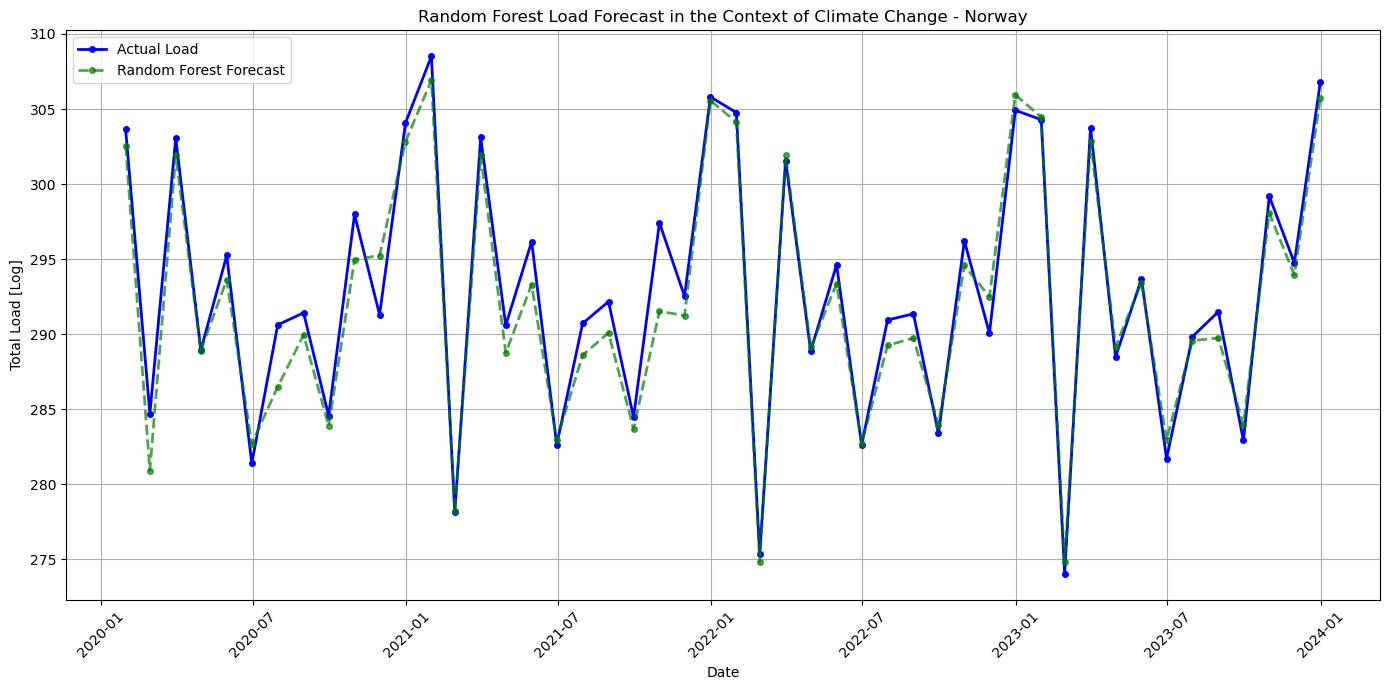

In [32]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_ml_2.index, y_test_ml_2, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=2,markersize=8)
plt.plot(y_test_ml_2.index, predictions_ml_2, label='Random Forest Forecast', color='green', alpha=0.7, marker='.', linestyle='--', linewidth=2,markersize=8)

plt.title('Random Forest Load Forecast in the Context of Climate Change - Norway')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Enhancing readability with a grid
plt.tight_layout()
# Save the plot to the specified folder
plt.savefig(os.path.join(my_plots, 'rf_model_2_comparison.png'), dpi=600)  # Save as PNG format at high resolution

plt.show()

# GB

In [33]:
# Model Selection: Gradient Boosting Regressor for the expanded mode
gb_regressor_2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Training the second model with the training data including holidays
gb_regressor_2.fit(X_train_ml_scaled_2, y_train_ml_2)

# Making predictions with the second model on the test data
predictions_gb_2 = gb_regressor_2.predict(X_test_ml_scaled_2)

# Evaluating the second model
mse_gb_2 = mean_squared_error(y_test_ml_2, predictions_gb_2)
rmse_gb_2 = np.sqrt(mse_gb_2)
mae_gb_2 = mean_absolute_error(y_test_ml_2, predictions_gb_2)
mape_gb_2 = np.mean(np.abs((y_test_ml_2 - predictions_gb_2) / y_test_ml_2)) * 100

print("MSE for GB Model 2:", mse_gb_2)
print("RMSE for GB Model 2:", rmse_gb_2)
print("MAE for GB Model 2:", mae_gb_2)
print("MAPE for GB Model 2:", mape_gb_2)

MSE for GB Model 2: 2.475580009578318
RMSE for GB Model 2: 1.5733976006014239
MAE for GB Model 2: 1.2206708415495744
MAPE for GB Model 2: 0.4154745165853112


In [34]:
# Making predictions on the training set for the Gradient Boosting model
train_predictions_gb_2 = gb_regressor_2.predict(X_train_ml_scaled_2)

# Evaluating the model on the training set
mse_in_sample_gb_2 = mean_squared_error(y_train_ml_2, train_predictions_gb_2)
rmse_in_sample_gb_2 = np.sqrt(mse_in_sample_gb_2)
mae_in_sample_gb_2 = mean_absolute_error(y_train_ml_2, train_predictions_gb_2)
mape_in_sample_gb_2 = np.mean(np.abs((y_train_ml_2 - train_predictions_gb_2) / y_train_ml_2)) * 100

# Printing the in-sample evaluation metrics for the Gradient Boosting Regressor 2
print("In-sample Evaluation Metrics for Gradient Boosting Regressor 2:")
print(f"MSE (In-sample): {mse_in_sample_gb_2}")
print(f"RMSE (In-sample): {rmse_in_sample_gb_2}")
print(f"MAE (In-sample): {mae_in_sample_gb_2}")
print(f"MAPE (In-sample): {mape_in_sample_gb_2}%")

In-sample Evaluation Metrics for Gradient Boosting Regressor 2:
MSE (In-sample): 0.20544713889187008
RMSE (In-sample): 0.45326277024687356
MAE (In-sample): 0.339221004515422
MAPE (In-sample): 0.11719478869015545%


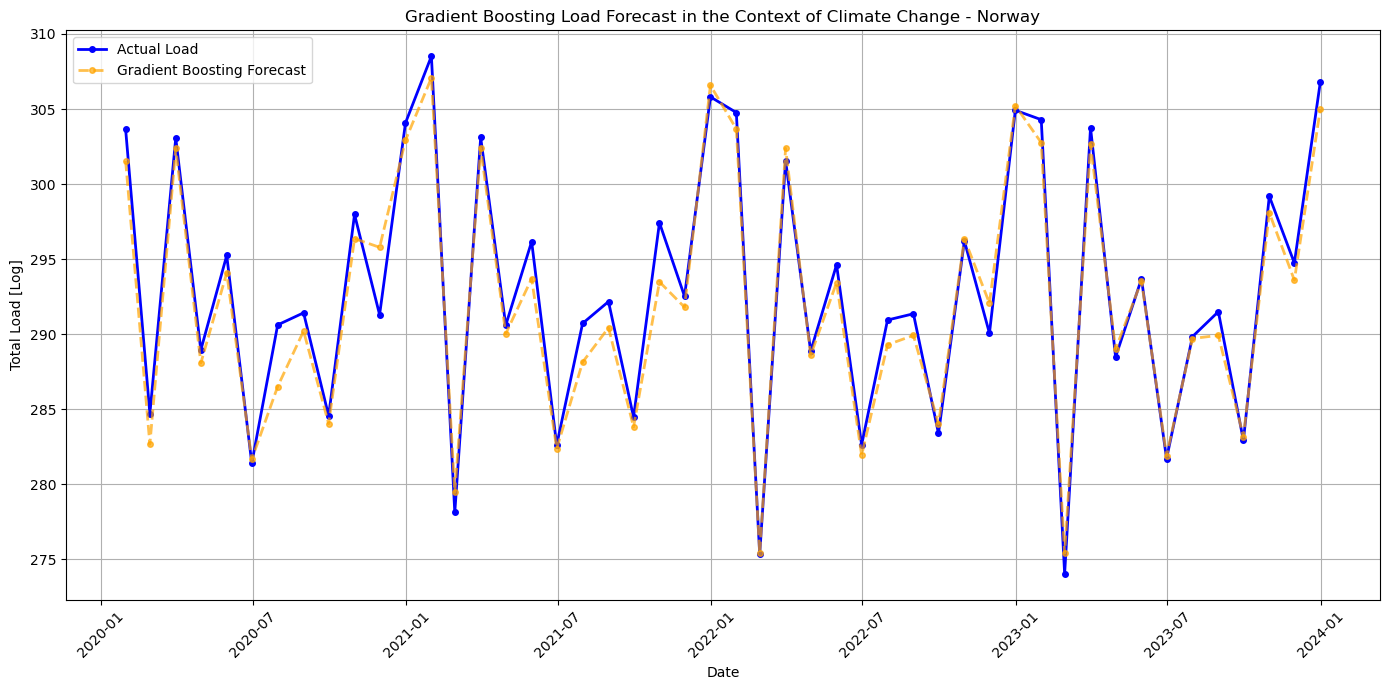

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_ml_2.index, y_test_ml_2, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=2,markersize=8)
plt.plot(y_test_ml_2.index, predictions_gb_2, label='Gradient Boosting Forecast', color='orange', alpha=0.7, marker='.', linestyle='--', linewidth=2,markersize=8)

plt.title('Gradient Boosting Load Forecast in the Context of Climate Change - Norway')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  
plt.tight_layout()

plt.savefig(os.path.join(my_plots, 'gb_model_2_comparison.png'), dpi=600)  # Save as PNG format at high resolution

plt.show()

### Measuring the importance of features in the ML models

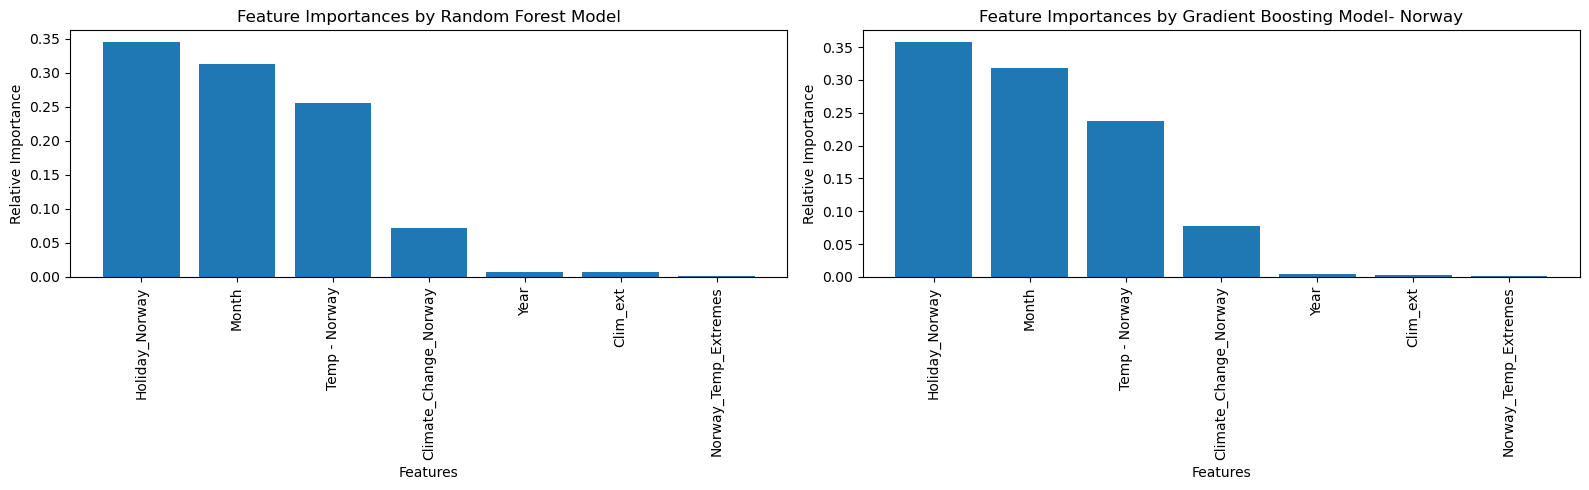

In [36]:
features_ext = ['Temp - Norway', 'Month', 'Year', 'Holiday_Norway', 'Norway_Temp_Extremes', 'Climate_Change_Norway','Clim_ext']

# Getting feature importances from both models
importances_rf = rf_regressor_2.feature_importances_
importances_gb = gb_regressor_2.feature_importances_

# Sorting the feature importances in descending order and create indices to arrange them on the x-axis
indices_rf = np.argsort(importances_rf)[::-1]
indices_gb = np.argsort(importances_gb)[::-1]

# Plotting Random Forest feature importances and Gradient Boosting feature importances side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plotting Random Forest feature importances
axes[0].bar(range(len(indices_rf)), importances_rf[indices_rf], align='center')
axes[0].set_title('Feature Importances by Random Forest Model')
axes[0].set_xticks(range(len(indices_rf)))
axes[0].set_xticklabels([features_ext[i] for i in indices_rf], rotation=90)
axes[0].set_ylabel('Relative Importance')
axes[0].set_xlabel('Features')

# Plotting Gradient Boosting feature importances
axes[1].bar(range(len(indices_gb)), importances_gb[indices_gb], align='center')
axes[1].set_title('Feature Importances by Gradient Boosting Model- Norway')
axes[1].set_xticks(range(len(indices_gb)))
axes[1].set_xticklabels([features_ext[i] for i in indices_gb], rotation=90)
axes[1].set_ylabel('Relative Importance')
axes[1].set_xlabel('Features')

plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'gb_feature_comparison.png'), dpi=600)  # Save as PNG format at high resolution
plt.show()


# NOW LET’S BUILD THE RESILIENT ELECTRICITY DEMAND FORECASTS IN THE FACE OF CLIMATE CHANGE USING OUR ML MODELS

In [37]:
# Temperature ranges
summer_temperature_range = np.linspace(10, 35, 100)  # From mild to extreme summer temperatures
winter_temperature_range = np.linspace(-20, 10, 100)  # From extreme to mild winter temperatures

In [38]:
# Preparing my DataFrames
summer_df = pd.DataFrame({
    'Temp - Norway': summer_temperature_range,
    'Norway_Temp_Extremes': (summer_temperature_range > 30).astype(int)  # Extreme if > 30°C
})

winter_df = pd.DataFrame({
    'Temp - Norway': winter_temperature_range,
    'Norway_Temp_Extremes': (winter_temperature_range > 0).astype(int)  # Extreme if < -15°C
})

In [39]:
dump(rf_regressor, 'rf_regressor.joblib')
dump(gb_regressor, 'gb_regressor.joblib')

['gb_regressor.joblib']

In [40]:
# Adding 'Month' and 'Year' to the prediction DataFrames with placeholder values
summer_df['Month'] = 7  # Typical summer month
summer_df['Year'] = 2018  # Placeholder year

winter_df['Month'] = 12  # Typical winter month
winter_df['Year'] = 2010  # Placeholder year

# Making sure to use the same feature ordering as during training
prediction_features = ['Temp - Norway', 'Month', 'Year']

# Scaling the prediction DataFrames
summer_df_scaled = scaler.transform(summer_df[prediction_features])
winter_df_scaled = scaler.transform(winter_df[prediction_features])

# Performing predictions with the scaled DataFrames
rf_predictions_summer = rf_regressor.predict(summer_df_scaled)
gb_predictions_summer = gb_regressor.predict(summer_df_scaled)

rf_predictions_winter = rf_regressor.predict(winter_df_scaled)
gb_predictions_winter = gb_regressor.predict(winter_df_scaled)

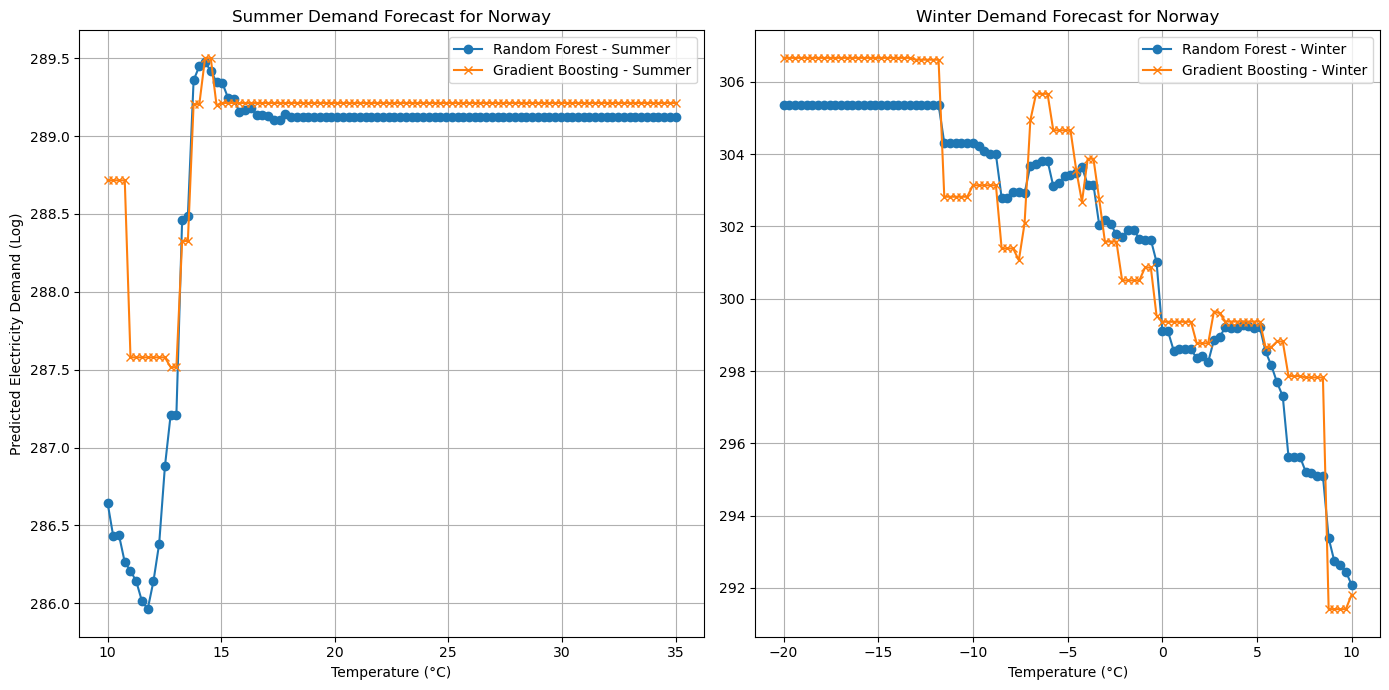

In [41]:
plt.figure(figsize=(14, 7))

# Summer Predictions
plt.subplot(1, 2, 1)
plt.plot(summer_df['Temp - Norway'], rf_predictions_summer, label='Random Forest - Summer', linestyle='-', marker='o')
plt.plot(summer_df['Temp - Norway'], gb_predictions_summer, label='Gradient Boosting - Summer', linestyle='-', marker='x')
plt.title('Summer Demand Forecast for Norway')
plt.xlabel('Temperature (°C)')
plt.ylabel('Predicted Electricity Demand (Log)')
plt.legend()
plt.grid(True)  # Adding grid to the summer predictions plot

# Winter Predictions
plt.subplot(1, 2, 2)
plt.plot(winter_df['Temp - Norway'], rf_predictions_winter, label='Random Forest - Winter', linestyle='-', marker='o')
plt.plot(winter_df['Temp - Norway'], gb_predictions_winter, label='Gradient Boosting - Winter', linestyle='-', marker='x')
plt.title('Winter Demand Forecast for Norway')
plt.xlabel('Temperature (°C)')
plt.legend()
plt.grid(True)  # Adding grid to the winter predictions plot
plt.savefig(os.path.join(my_plots, 'plot8.png'), dpi = 600)  # Save as PNG format
plt.tight_layout()
plt.show()

## LETS SEE HOW TO IMPROVE ON TRADITIONAL AND MACHINE LEARNING MODELS. NOT IMPORTANT BUT TO TEST

#### ENSEMBLE METHOD: SARIMAX WITH RANDOM FOREST

In [42]:
# SARIMAX forecasts ( already fits the model to the training data)
sarimax_forecasts = sarimax_result2.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test_exog)

In [43]:
# Combining the forecasts using averaging
ensemble_forecasts = (sarimax_forecasts + predictions_ml_2) / 2

In [44]:
# Evaluation metrics for the ensemble forecasts
mse_ensemble = mean_squared_error(y_test_ml_2, ensemble_forecasts)
rmse_ensemble = np.sqrt(mse_ensemble)
mae_ensemble = mean_absolute_error(y_test_ml_2, ensemble_forecasts)
mape_ensemble = np.mean(np.abs((y_test_ml_2 - ensemble_forecasts) / y_test_ml_2)) * 100

print(f"Ensemble Forecast MSE: {mse_ensemble}")
print(f"Ensemble Forecast RMSE: {rmse_ensemble}")
print(f"Ensemble Forecast MAE: {mae_ensemble}")
print(f"Ensemble Forecast MAPE: {mape_ensemble}%")

Ensemble Forecast MSE: 2.3674174172891216
Ensemble Forecast RMSE: 1.538641419333667
Ensemble Forecast MAE: 1.0212045208066993
Ensemble Forecast MAPE: 0.3498408512263266%


In [45]:
# Making predictions on the training set for SARIMAX and ML models
sarimax_train_predictions = sarimax_result.predict(start=y_train.index[0], end=y_train.index[-1], exog=X_train_ml_scaled)
ml_train_predictions = rf_regressor.predict(X_train_ml_scaled)

# Combining the forecasts using averaging for the training set
ensemble_train_forecasts = (sarimax_train_predictions + ml_train_predictions) / 2

# Evaluating the ensemble model on the training set
mse_in_sample_ensemble = mean_squared_error(y_train_ml_2, ensemble_train_forecasts)
rmse_in_sample_ensemble = np.sqrt(mse_in_sample_ensemble)
mae_in_sample_ensemble = mean_absolute_error(y_train_ml_2, ensemble_train_forecasts)
mape_in_sample_ensemble = np.mean(np.abs((y_train_ml_2 - ensemble_train_forecasts) / y_train_ml_2)) * 100

# Printing the in-sample evaluation metrics
print("In-sample Evaluation Metrics for Ensemble Forecast:")
print(f"MSE (In-sample): {mse_in_sample_ensemble}")
print(f"RMSE (In-sample): {rmse_in_sample_ensemble}")
print(f"MAE (In-sample): {mae_in_sample_ensemble}")
print(f"MAPE (In-sample): {mape_in_sample_ensemble}%")

In-sample Evaluation Metrics for Ensemble Forecast:
MSE (In-sample): 243.28088779113034
RMSE (In-sample): 15.597464146172298
MAE (In-sample): 2.9635993819241246
MAPE (In-sample): 0.9902877335897826%


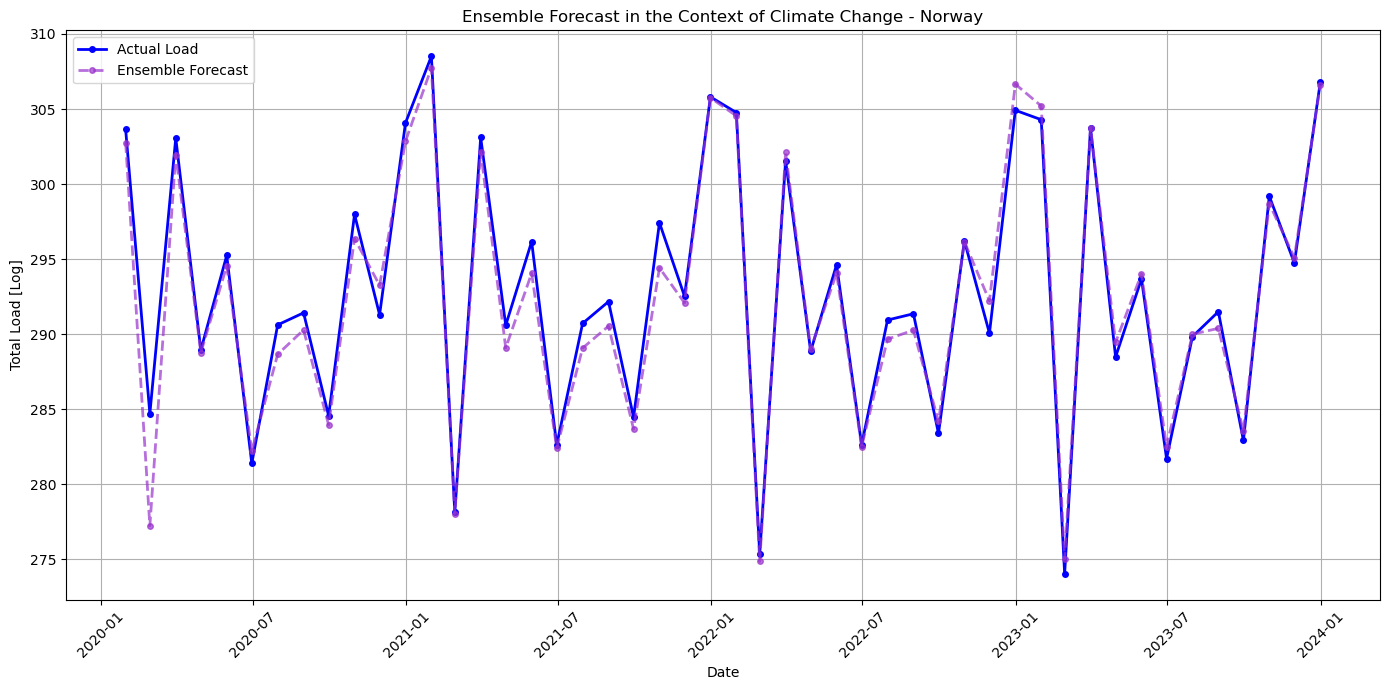

In [46]:
# Plotting the actual vs. ensemble forecasts
plt.figure(figsize=(14, 7))

# Actual load data
plt.plot(y_test_ml.index, y_test_ml, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=2, markersize=8)

# Ensemble forecasts
plt.plot(y_test_ml.index, ensemble_forecasts, label='Ensemble Forecast', color='darkorchid', alpha=0.7, marker='.', linestyle='--', linewidth=2, markersize=8)

plt.title('Ensemble Forecast in the Context of Climate Change - Norway')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'plot9.png'), dpi = 600)  # Save as PNG format
plt.show()

#### ENHANCED METHOD: SARIMAX WITH GRADIENT BOOSTING. THESE WERE JUST TO TEST AND NOT IMPORTANT TO THE THESIS

In [47]:
# Step 1: Generating SARIMAX Forecasts for Both Training and Testing Datasets
# For my training, this implies generating in-sample forecasts to use as a feature
sarimax_forecasts_train = sarimax_result2.predict(start=y_train.index[0], end=y_train.index[-1], exog=X_train_exog)
sarimax_forecasts_test = sarimax_result2.forecast(steps=len(y_test), exog=X_test_exog)

# Step 2: Adding the SARIMAX forecasts as a consistent feature across both datasets
X_train_enhanced = X_train.copy()
X_train_enhanced['SARIMAX_Feature'] = sarimax_forecasts_train
X_test_enhanced = X_test.copy()
X_test_enhanced['SARIMAX_Feature'] = sarimax_forecasts_test.values  # Ensuring alignment

# Step 3: Standardizing Features with Consistent Naming
scaler = StandardScaler()
# Combining, scaling, and then splitting the datasets to ensure the scaler is applied uniformly
X_combined = pd.concat([X_train_enhanced, X_test_enhanced])
X_combined_scaled = scaler.fit_transform(X_combined)
# Splitting back into training and testing sets
split_index = len(X_train_enhanced)
X_train_enhanced_scaled = X_combined_scaled[:split_index]
X_test_enhanced_scaled = X_combined_scaled[split_index:]

# Step 4: Training the Gradient Boosting Model with Enhanced Features
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_regressor.fit(X_train_enhanced_scaled, y_train)

# Step 5: Making Predictions and Evaluating
predictions_gb = gb_regressor.predict(X_test_enhanced_scaled)
mse_gb = mean_squared_error(y_test, predictions_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test, predictions_gb)
mape_gb = np.mean(np.abs((y_test - predictions_gb) / y_test)) * 100

print(f"Gradient Boosting Enhanced Model - MSE: {mse_gb}, RMSE: {rmse_gb}, MAE: {mae_gb}, MAPE: {mape_gb}%")

Gradient Boosting Enhanced Model - MSE: 9.34464341242286, RMSE: 3.056900949069639, MAE: 1.912088459548188, MAPE: 0.6568618921245655%


In [48]:
# Training the Gradient Boosting Model with Enhanced Features
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_regressor.fit(X_train_enhanced_scaled, y_train)

# Making Predictions on the training set
train_predictions_gb = gb_regressor.predict(X_train_enhanced_scaled)

#Evaluating the model on the training set
mse_in_sample_gb = mean_squared_error(y_train, train_predictions_gb)
rmse_in_sample_gb = np.sqrt(mse_in_sample_gb)
mae_in_sample_gb = mean_absolute_error(y_train, train_predictions_gb)
mape_in_sample_gb = np.mean(np.abs((y_train - train_predictions_gb) / y_train)) * 100

# Printing the in-sample evaluation metrics
print("In-sample Evaluation Metrics for Gradient Boosting Enhanced Model:")
print(f"MSE (In-sample): {mse_in_sample_gb}")
print(f"RMSE (In-sample): {rmse_in_sample_gb}")
print(f"MAE (In-sample): {mae_in_sample_gb}")
print(f"MAPE (In-sample): {mape_in_sample_gb}%")

In-sample Evaluation Metrics for Gradient Boosting Enhanced Model:
MSE (In-sample): 0.7166349612855367
RMSE (In-sample): 0.8465429471004626
MAE (In-sample): 0.6118877255285544
MAPE (In-sample): 0.21065413723806636%


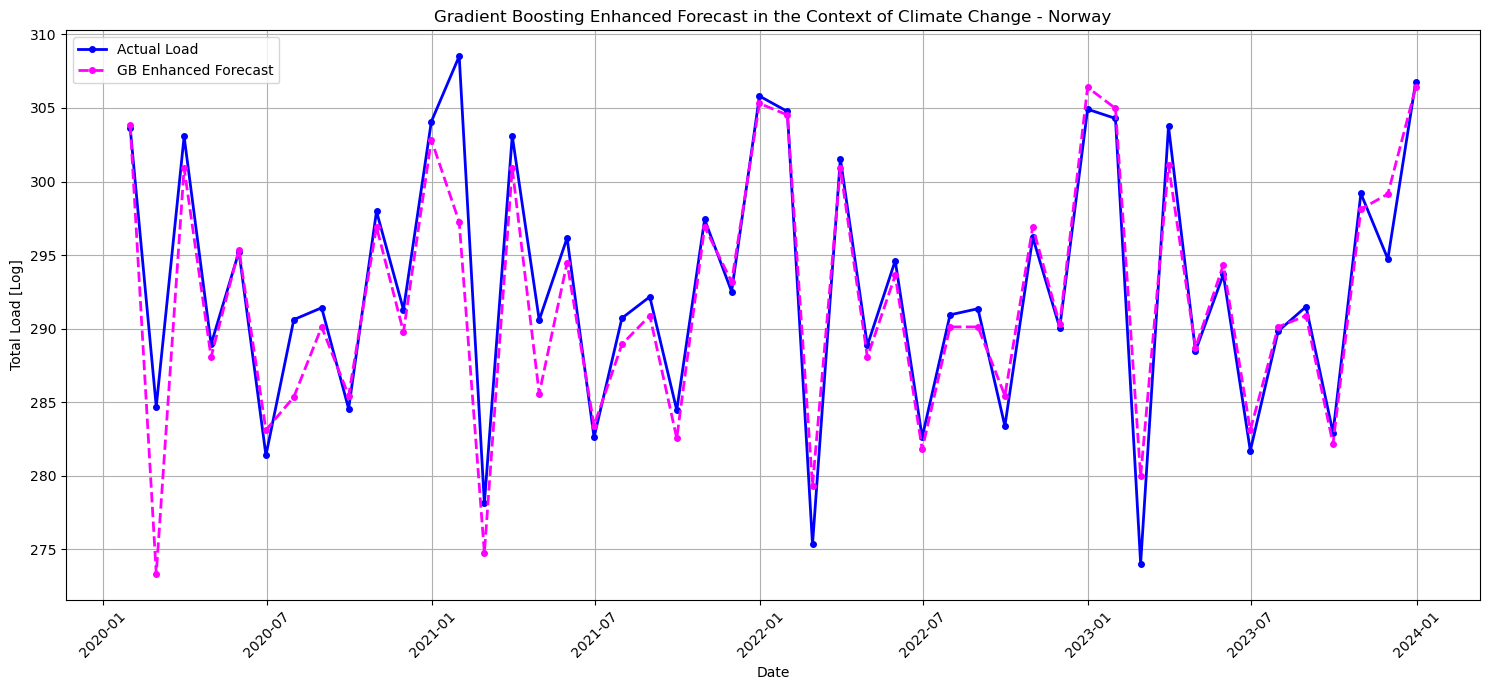

In [49]:
plt.figure(figsize=(15, 7))

# Plotting the actual load data
plt.plot(y_test.index, y_test, label='Actual Load', color='blue', linewidth=2, marker='.', linestyle='-', markersize=8)

# Plotting the Gradient Boosting predictions
plt.plot(y_test.index, predictions_gb, label='GB Enhanced Forecast', color='magenta', linewidth=2, marker='.', linestyle='--', markersize=8)

plt.title('Gradient Boosting Enhanced Forecast in the Context of Climate Change - Norway')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'plot10.png'), dpi = 600)  # Save as PNG format
plt.show()


## TIMES SERIES CROSS VALIDATION USING 10 SPLITS

In [50]:
# The Time series cross-validation setup
tscv = TimeSeriesSplit(n_splits=10)

# My lists to store scores for Random Forest
mse_scores_rf = []
mae_scores_rf = []
rmse_scores_rf = []
mape_scores_rf = []
r2_scores_rf = []

# My lists to store scores for Gradient Boosting
mse_scores_gb = []
mae_scores_gb = []
rmse_scores_gb = []
mape_scores_gb = []
r2_scores_gb = []

for train_index, test_index in tscv.split(X_train_ml_scaled_2):
    # Split data
    X_train_fold, X_test_fold = X_train_ml_scaled_2.iloc[train_index], X_train_ml_scaled_2.iloc[test_index]
    y_train_fold, y_test_fold = y_train_ml_2.iloc[train_index], y_train_ml_2.iloc[test_index]

    # Instantiate models
    rf_regressor_fold = RandomForestRegressor(n_estimators=100, random_state=42)
    gb_regressor_fold = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

    # Fit models
    rf_regressor_fold.fit(X_train_fold, y_train_fold)
    gb_regressor_fold.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    rf_predictions_fold = rf_regressor_fold.predict(X_test_fold)
    gb_predictions_fold = gb_regressor_fold.predict(X_test_fold)

    # Calculate and collect all metrics for each fold for Random Forest
    mse_scores_rf.append(mean_squared_error(y_test_fold, rf_predictions_fold))
    mae_scores_rf.append(mean_absolute_error(y_test_fold, rf_predictions_fold))
    rmse_scores_rf.append(np.sqrt(mean_squared_error(y_test_fold, rf_predictions_fold)))
    mape_scores_rf.append(np.mean(np.abs((y_test_fold - rf_predictions_fold) / y_test_fold)) * 100)
    r2_scores_rf.append(r2_score(y_test_fold, rf_predictions_fold))

    # Calculate and collect all metrics for each fold for Gradient Boosting
    mse_scores_gb.append(mean_squared_error(y_test_fold, gb_predictions_fold))
    mae_scores_gb.append(mean_absolute_error(y_test_fold, gb_predictions_fold))
    rmse_scores_gb.append(np.sqrt(mean_squared_error(y_test_fold, gb_predictions_fold)))
    mape_scores_gb.append(np.mean(np.abs((y_test_fold - gb_predictions_fold) / y_test_fold)) * 100)
    r2_scores_gb.append(r2_score(y_test_fold, gb_predictions_fold))

# Calculating the average of all metrics across all folds for each model
avg_mse_rf = np.mean(mse_scores_rf)
avg_mae_rf = np.mean(mae_scores_rf)
avg_rmse_rf = np.mean(rmse_scores_rf)
avg_mape_rf = np.mean(mape_scores_rf)
avg_r2_rf = np.mean(r2_scores_rf)

avg_mse_gb = np.mean(mse_scores_gb)
avg_mae_gb = np.mean(mae_scores_gb)
avg_rmse_gb = np.mean(rmse_scores_gb)
avg_mape_gb = np.mean(mape_scores_gb)
avg_r2_gb = np.mean(r2_scores_gb)

# Printing out the average metrics for both models
print(f"Random Forest - MSE: {avg_mse_rf}, MAE: {avg_mae_rf}, RMSE: {avg_rmse_rf}, MAPE: {avg_mape_rf}, R2: {avg_r2_rf}")
print(f"Gradient Boosting - MSE: {avg_mse_gb}, MAE: {avg_mae_gb}, RMSE: {avg_rmse_gb}, MAPE: {avg_mape_gb}, R2: {avg_r2_gb}")


Random Forest - MSE: 15.591082388314518, MAE: 2.643282729297847, RMSE: 3.5468245040506865, MAPE: 0.9084955780324376, R2: 0.7837632812099822
Gradient Boosting - MSE: 14.176960825326622, MAE: 2.4639074955672786, RMSE: 3.3516946067430666, MAPE: 0.8506467016016845, R2: 0.8018814689325318


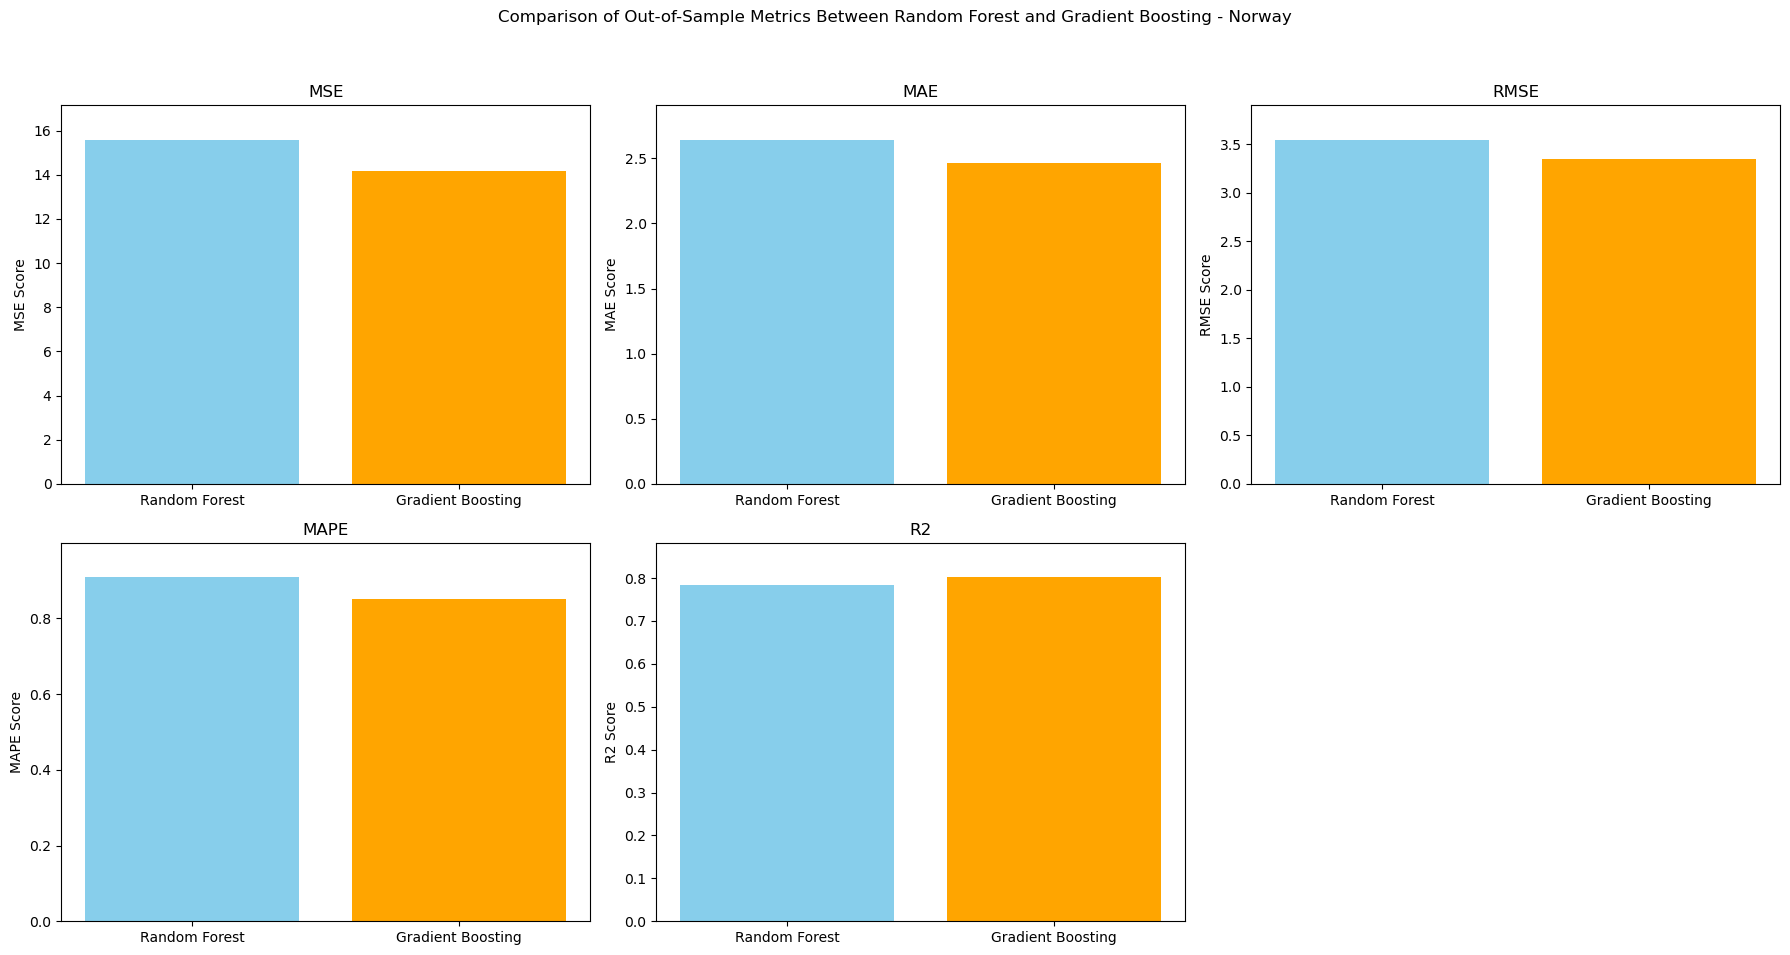

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparison of Out-of-Sample Metrics Between Random Forest and Gradient Boosting - Norway')

# List of metrics for plotting
metrics_values = [(avg_mse_rf, avg_mse_gb, 'MSE'), 
                  (avg_mae_rf, avg_mae_gb, 'MAE'), 
                  (avg_rmse_rf, avg_rmse_gb, 'RMSE'), 
                  (avg_mape_rf, avg_mape_gb, 'MAPE'), 
                  (avg_r2_rf, avg_r2_gb, 'R2')]

# Plotting each metric in a separate subplot
for ax, (rf_val, gb_val, metric_name) in zip(axes.flatten(), metrics_values):
    ax.bar('Random Forest', rf_val, color='skyblue')
    ax.bar('Gradient Boosting', gb_val, color='orange')
    ax.set_title(metric_name)
    ax.set_ylabel(metric_name + ' Score')
    ax.set_ylim(0, max(rf_val, gb_val) * 1.1)  # Setting y limit for better comparison

# Hiding the 6th subplot (as we have only 5 metrics)
axes[1, 2].set_visible(False)
plt.savefig(os.path.join(my_plots, 'plot11.png'), dpi = 600)  # Save as PNG format
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

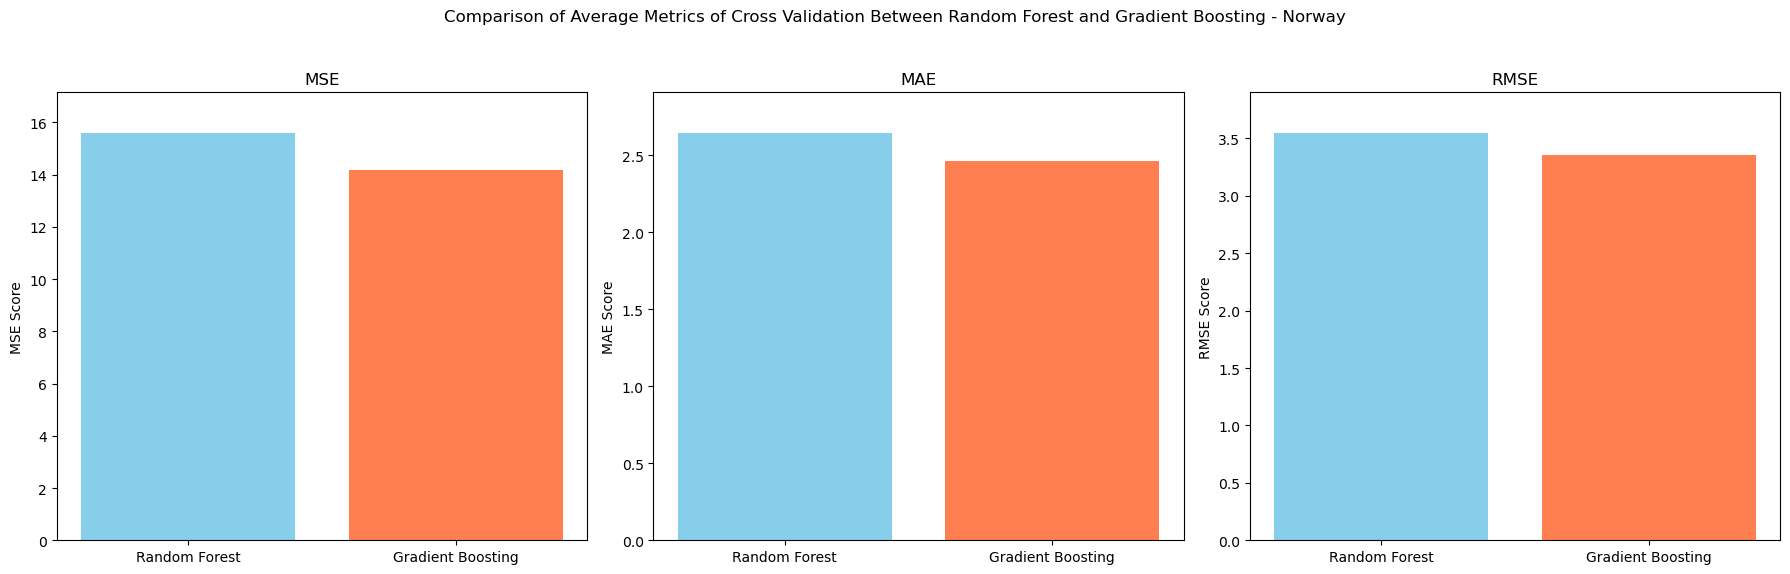

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjusted for a 1x3 grid
fig.suptitle('Comparison of Average Metrics of Cross Validation Between Random Forest and Gradient Boosting - Norway')

# my values defined here
#avg_mse_rf, avg_mse_gb = 1217717.567079088, 1044886.5317915119
#avg_mae_rf, avg_mae_gb = 892.0145622816465, 831.2262394162437
#avg_rmse_rf, avg_rmse_gb = 1102.0497905156303, 1019.703103435139

# List of metrics for plotting, updated to include only MSE, MAE, RMSE
metrics_values = [
    (avg_mse_rf, avg_mse_gb, 'MSE'), 
    (avg_mae_rf, avg_mae_gb, 'MAE'), 
    (avg_rmse_rf, avg_rmse_gb, 'RMSE')
]

# Plotting each metric in a separate subplot
for ax, (rf_val, gb_val, metric_name) in zip(axes, metrics_values):
    ax.bar('Random Forest', rf_val, color='skyblue')
    ax.bar('Gradient Boosting', gb_val, color='coral')
    ax.set_title(metric_name)
    ax.set_ylabel(metric_name + ' Score')
    ax.set_ylim(0, max(rf_val, gb_val) * 1.1)  # Setting y limit for better comparison

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(my_plots, 'plot11.png'), dpi=600)  # Save as PNG format
plt.show()

The Gradient Boosting model generally outperforms the Random Forest model across all metrics. The Gradient Boosting model has lower MSE, MAE, RMSE, MAPE, and higher R2 compared to the Random Forest model. This indicates that the Gradient Boosting model provides better predictions and captures more variance in the data.
Based on these evaluation metrics, the Gradient Boosting appears to be the **MOST RESILIENT MACHINE LEARNING** model.

# ENHANCING THE MODELS TO BETTER THE PERFORMANCE OF THE FORECASTS

#### WEIGHTED & RF

In [53]:
# Calculate error metrics for each model
#mse_sarimax = mean_squared_error(y_test_ml_2, sarimax_forecasts)
#mse_ml_2 = mean_squared_error(y_test_ml_2, predictions_ml_2)

# Assigning weights inversely proportional to MSE
weight_sarimax = 1 / mse_sarimax2
weight_ml_2 = 1 / mse_ml_2

# Normalizing weights
total_weight = weight_sarimax + weight_ml_2
weight_sarimax /= total_weight
weight_ml_2 /= total_weight

# Combining the forecasts using weighted average
ensemble_forecasts = (sarimax_forecasts * weight_sarimax + predictions_ml_2 * weight_ml_2)

# Evaluatig metrics for the ensemble forecasts
mse_ensemble = mean_squared_error(y_test_ml_2, ensemble_forecasts)
rmse_ensemble = np.sqrt(mse_ensemble)
mae_ensemble = mean_absolute_error(y_test_ml_2, ensemble_forecasts)
mape_ensemble = np.mean(np.abs((y_test_ml_2 - ensemble_forecasts) / y_test_ml_2)) * 100

print(f"Ensemble Forecast MSE: {mse_ensemble}")
print(f"Ensemble Forecast RMSE: {rmse_ensemble}")
print(f"Ensemble Forecast MAE: {mae_ensemble}")
print(f"Ensemble Forecast MAPE: {mape_ensemble}%")

Ensemble Forecast MSE: 2.3667660255560383
Ensemble Forecast RMSE: 1.538429727207596
Ensemble Forecast MAE: 1.0257620591729466
Ensemble Forecast MAPE: 0.3513651720298753%


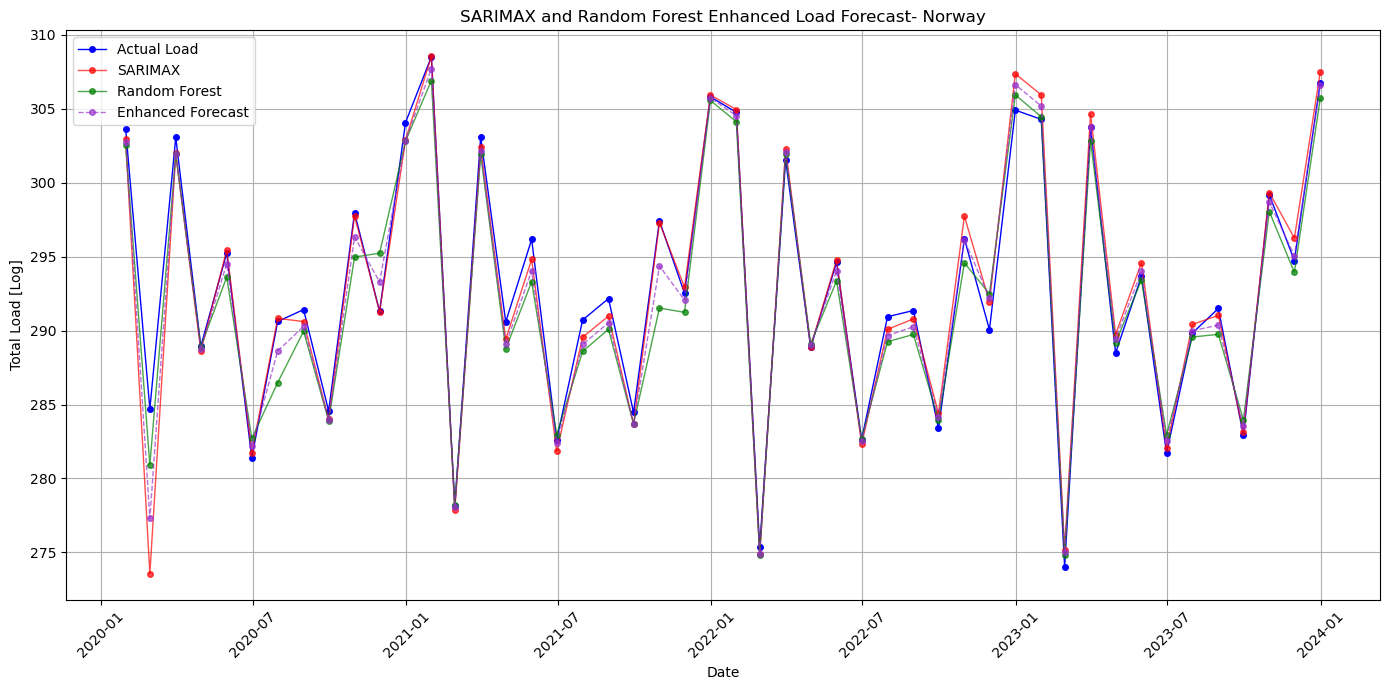

In [54]:
plt.figure(figsize=(14, 7))

# Plot actual load data
plt.plot(y_test_ml_2.index, y_test_ml_2, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=1, markersize=8)

# Plot individual model forecasts
plt.plot(y_test_ml_2.index, sarimax_forecasts, label='SARIMAX', color='red', alpha=0.7, marker='.', linestyle='-', linewidth=1, markersize=8)
plt.plot(y_test_ml_2.index, predictions_ml_2, label='Random Forest', color='green', alpha=0.7, marker='.', linestyle='-', linewidth=1, markersize=8)

# Plot ensemble forecasts
plt.plot(y_test_ml_2.index, ensemble_forecasts, label='Enhanced Forecast', color='darkorchid', alpha=0.7, marker='.', linestyle='--', linewidth=1, markersize=8)

# Customizing the plot
plt.title('SARIMAX and Random Forest Enhanced Load Forecast- Norway')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'comp1.png'), dpi = 1000)  # Save as PNG format


### WEIGHTED & GB

In [55]:
# Calculating inverse weights based on RMSE
weight_sarimax = 1 / mse_sarimax2
weight_gb = 1 / mse_gb_2

# Normalizing the weights so that they sum to 1
total_weight2 = weight_sarimax + weight_gb
weight_sarimax /= total_weight2
weight_gb /= total_weight2

# Combining predictions using weighted average
combined_predictions = (sarimax_forecasts * weight_sarimax + predictions_gb_2 * weight_gb)


In [56]:
# EvaluatING the ensemble model's performance
mse_combined = mean_squared_error(y_test_ml_2, combined_predictions)
rmse_combined = np.sqrt(mse_combined)
mae_combined = mean_absolute_error(y_test_ml_2, combined_predictions)
mape_combined = np.mean(np.abs((y_test_ml_2 - combined_predictions) / y_test_ml_2)) * 100

# Print results
print(f"Combined Model MSE: {mse_combined}")
print(f"Combined Model RMSE: {rmse_combined}")
print(f"Combined Model MAE: {mae_combined}")
print(f"Combined Model MAPE: {mape_combined}%")

Combined Model MSE: 1.8518478671501015
Combined Model RMSE: 1.360826170805846
Combined Model MAE: 0.9795429658662099
Combined Model MAPE: 0.3351661594108688%


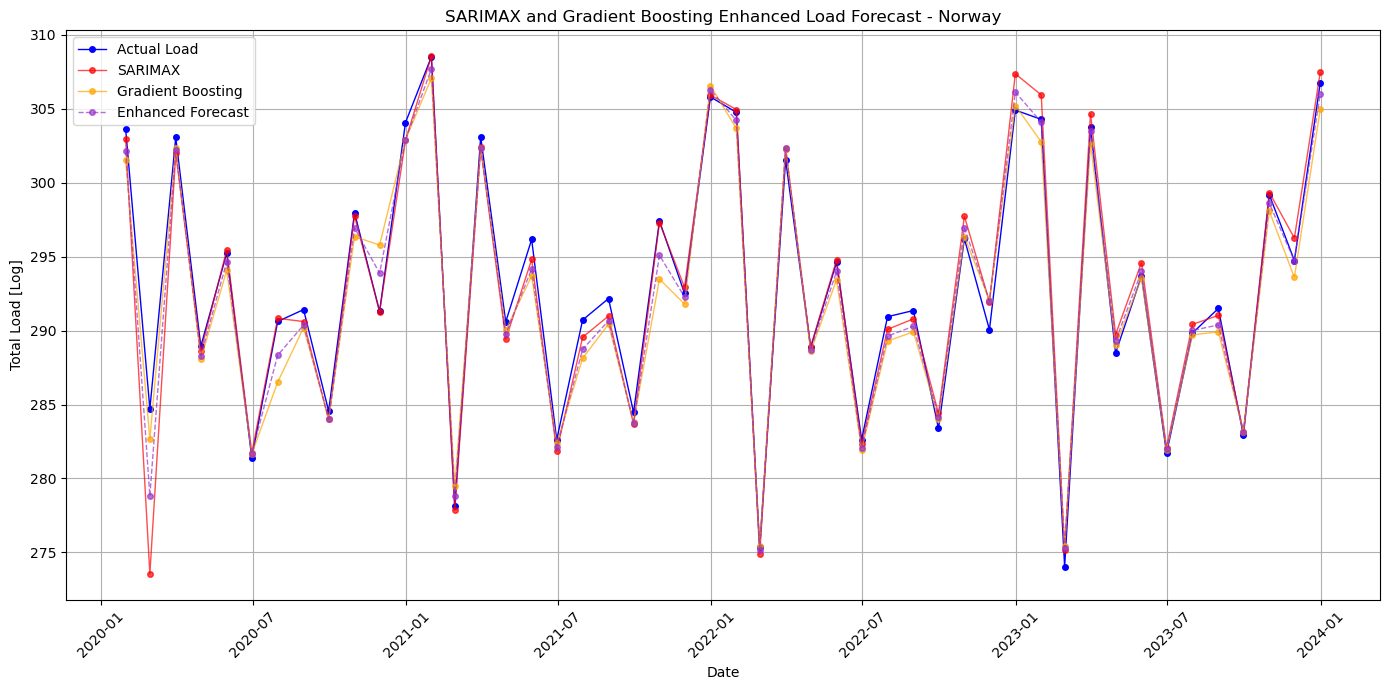

In [57]:
plt.figure(figsize=(14, 7))

# Plot actual load data
plt.plot(y_test_ml_2.index, y_test_ml_2, label='Actual Load', color='blue', marker='.', linestyle='-', linewidth=1, markersize=8)

# Plot individual model forecasts
plt.plot(y_test_ml_2.index, sarimax_forecasts, label='SARIMAX', color='red', alpha=0.7, marker='.', linestyle='-', linewidth=1, markersize=8)
plt.plot(y_test_ml_2.index, predictions_gb_2, label='Gradient Boosting', color='orange', alpha=0.7, marker='.', linestyle='-', linewidth=1, markersize=8)

# Plot ensemble forecasts
plt.plot(y_test_ml_2.index, combined_predictions, label='Enhanced Forecast', color='darkorchid', alpha=0.7, marker='.', linestyle='--', linewidth=1, markersize=8)

# Customizing the plot
plt.title('SARIMAX and Gradient Boosting Enhanced Load Forecast - Norway')
plt.xlabel('Date')
plt.ylabel('Total Load [Log]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'comp2.png'), dpi = 1000)  # Save as PNG format

# Display the plot
plt.show()